# Описание проекта. Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучите его, прежде чем генерировать новые признаки.

Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

**ОГЛАВЛЕНИЕ**

<a href='#1'>Загрузка данных</a>

<a href='#2'>Исследовательский анализ и предобработка данных</a>

<a href='#3'>Объединение таблиц</a>

<a href='#4'>Корреляционный анализ</a>

<a href='#6'>Обучение модели</a>

<a href='#7'>Тестирование модели</a>

<a href='#8'>Важность основных признаков</a>

<a href='#9'>Выводы</a>

In [1]:
%reload_ext autoreload

In [2]:
!pip install sqlalchemy -q

#!pip install --upgrade ipython-sql sqlalchemy -q

#!pip install --upgrade pandas -q

!pip install phik -q

!pip install scikit-learn==1.1.3 -q

!pip install shap -q

!pip install catboost -q

In [3]:
import os
from sqlalchemy import create_engine

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

import seaborn as sns
from matplotlib import pyplot as plt

from phik.report import correlation_report, plot_correlation_matrix



from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import cv, Pool



from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             mean_absolute_error, 
                             mean_squared_error,
                             precision_score,
                             recall_score,
                             r2_score
                            )
    
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    train_test_split
)


from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)

from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

#from sklearn.dummy import DummyClassifier
#from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyRegressor

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
#from keras.optimizers import Adam

import shap

from shap import Explanation, KernelExplainer
from shap.plots import waterfall, beeswarm

import datetime
from datetime import date
from datetime import time

from sqlalchemy import create_engine

from sklearn.utils.validation import _num_samples

RANDOM_STATE = 110825
TEST_SIZE = 0.25

In [4]:
!wget https://code.s3.yandex.net/data-scientist/ds-plus-final.db

--2025-08-16 13:04:13--  https://code.s3.yandex.net/data-scientist/ds-plus-final.db
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3588096 (3.4M) [application/octet-stream]
Saving to: ‘ds-plus-final.db.30’

ds-plus-final.db.30 100%[===================>]   3.42M  --.-KB/s    in 0.08s   

2025-08-16 13:04:14 (44.7 MB/s) - ‘ds-plus-final.db.30’ saved [3588096/3588096]



In [5]:
path_to_db = 'ds-plus-final.db'
engine = create_engine(f'sqlite:///{path_to_db}', echo=False)

<a id='1'></a>
## Загрузка данных

Проверим наличие таблиц в базе данных.

In [6]:
query_01 = '''
SELECT name FROM sqlite_master WHERE type='table';
'''

In [7]:
dataname_df = pd.read_sql_query(query_01, con = engine)

In [8]:
dataname_df

,name
0,data_arc
1,data_bulk
2,data_bulk_time
3,data_wire_time
4,contract
5,personal
6,phone
7,internet
8,data_gas
9,data_temp


Есть все, необходимые для исследования таблицы и даже лишние.

In [9]:
query_1 = '''
SELECT *
FROM data_arc
'''

In [10]:
data_arc = pd.read_sql_query(query_1, con = engine)

In [11]:
def data_info(data):
    pd.set_option('display.max_columns', None)
    display(data.head())
    display(data.describe(include='all'))
    data.info()

In [12]:
data_info(data_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
count,14876.000000,14876,14876,14876.000000,14876.000000
unique,NaN,14876,14876,NaN,NaN
top,NaN,2019-05-25 10:53:23,2019-05-26 19:38:42,NaN,NaN
freq,NaN,1,1,NaN,NaN
mean,1615.220422,NaN,NaN,0.662752,0.438986
std,934.571502,NaN,NaN,0.258885,5.873485
min,1.000000,NaN,NaN,0.223120,-715.479924
25%,806.000000,NaN,NaN,0.467115,0.337175
50%,1617.000000,NaN,NaN,0.599587,0.441639
75%,2429.000000,NaN,NaN,0.830070,0.608201


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


В таблице с данными об электродах data_arc 14876 строк. Требуется изменение типа данных для полей с датами. В столбце реактивная мощность есть отрицательные значения, которые надо удалить.

In [13]:
query_2 = '''
SELECT *
FROM data_bulk
'''

In [14]:
data_bulk = pd.read_sql_query(query_2, con = engine)

In [15]:
data_info(data_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77,576,25,1,19,176,177,2450,18,2806,2248
unique,NaN,NaN,NaN,NaN,NaN,55,205,25,1,10,77,101,331,14,284,156
top,NaN,NaN,NaN,NaN,NaN,74.0,76.0,92.0,49.0,66.0,105.0,18.0,206.0,154.0,102.0,104.0
freq,NaN,NaN,NaN,NaN,NaN,5,15,1,1,4,8,7,224,3,99,223
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,933.337642,18.277654,21.180578,75.483494,48.184126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,10.000000,228.000000,6.000000,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,816.000000,27.000000,242.000000,58.000000,72.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     object 
 6   Bulk 6   576 non-null    object 
 7   Bulk 7   25 non-null     object 
 8   Bulk 8   1 non-null      object 
 9   Bulk 9   19 non-null     object 
 10  Bulk 10  176 non-null    object 
 11  Bulk 11  177 non-null    object 
 12  Bulk 12  2450 non-null   object 
 13  Bulk 13  18 non-null     object 
 14  Bulk 14  2806 non-null   object 
 15  Bulk 15  2248 non-null   object 
dtypes: float64(4), int64(1), object(11)
memory usage: 391.2+ KB


В таблице с данными об объёме сыпучих материалов data_bulk 3129 строк. Требуется изменение типа данных для полей с Bulk 5 - Bulk 15. Очень много пропусков, которые означают, что данный материал не добавляли в плавку.

In [16]:
query_3 = '''
SELECT *
FROM data_bulk_time
'''

In [17]:
data_bulk_time = pd.read_sql_query(query_3, con = engine)

In [18]:
data_info(data_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
unique,NaN,252,22,1298,1014,77,576,25,1,19,176,177,2450,18,2806,2248
top,NaN,2019-06-13 09:26:07,2019-08-12 21:42:20,2019-05-30 21:29:23,2019-06-20 12:20:31,2019-05-07 22:32:04,2019-06-24 05:37:36,2019-08-13 04:19:43,2019-07-08 17:14:53,2019-08-16 07:52:37,2019-07-31 12:22:40,2019-05-18 23:55:19,2019-07-08 06:49:10,2019-07-29 02:58:13,2019-06-09 02:45:29,2019-07-04 14:54:30
freq,NaN,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
mean,1624.383509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,933.337642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,816.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1622.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2431.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


В таблице с данными о времени подачи сыпучих материалов data_bulktime 3129 строк. Требуется изменение типа данных для полей с Bulk 1 - Bulk 15. Очень много пропусков, которые означают, что данный материал не добавляли в плавку.

In [19]:
query_4 = '''
SELECT *
FROM data_gas
'''

In [20]:
data_gas = pd.read_sql_query(query_4, con = engine)

In [21]:
data_info(data_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


В таблице с данными о продувке сплава газом data_gas 3239 строк. С типом данных все в порядке.

In [22]:
query_5 = '''
SELECT *
FROM data_temp
'''

In [23]:
data_temp = pd.read_sql_query(query_5, con = engine)

In [24]:
data_info(data_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


,key,Время замера,Температура
count,18092.000000,18092,14665
unique,NaN,18092,172
top,NaN,2019-05-24 16:06:27,1593.0
freq,NaN,1,445
mean,1616.460977,NaN,NaN
std,934.641385,NaN,NaN
min,1.000000,NaN,NaN
25%,807.750000,NaN,NaN
50%,1618.000000,NaN,NaN
75%,2429.000000,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


В таблице с данными об измерениях температуры data_temp 18092 строк. Требуется замена типов данных.

In [25]:
query_6 = '''
SELECT *
FROM data_wire
'''

In [26]:
data_wire = pd.read_sql_query(query_6, con = engine)

In [27]:
data_info(data_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079,63,14,1,73,11,19,29
unique,NaN,NaN,713,56,14,1,69,10,13,25
top,NaN,NaN,30.09968,0.144144,47.224323,15.132,18.086641,12.354473,46.187439000000005,30.066399
freq,NaN,NaN,20,3,1,1,2,2,3,3
mean,1623.426485,100.895853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,932.996726,42.012518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.918800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,823.000000,72.115684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1619.000000,100.158234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2434.000000,126.060483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   object 
 3   Wire 3  63 non-null     object 
 4   Wire 4  14 non-null     object 
 5   Wire 5  1 non-null      object 
 6   Wire 6  73 non-null     object 
 7   Wire 7  11 non-null     object 
 8   Wire 8  19 non-null     object 
 9   Wire 9  29 non-null     object 
dtypes: float64(1), int64(1), object(8)
memory usage: 240.8+ KB


В таблице с данными об объёме проволочных материалов data_wire 3081 строк. Требуется замена типов данных. Очень много пропусков, которые означают, что материал не добавляли в эту партию. 

In [28]:
query_7 = '''
SELECT *
FROM data_wire_time
'''

In [29]:
data_wire_time = pd.read_sql_query(query_7, con = engine)

In [30]:
data_info(data_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055,1079,63,14,1,73,11,19,29
unique,NaN,3055,1079,63,14,1,73,11,19,29
top,NaN,2019-08-12 14:59:32,2019-06-24 17:24:16,2019-05-07 23:37:44,2019-07-20 16:11:26,2019-08-13 06:14:30,2019-08-18 17:05:42,2019-08-13 07:49:49,2019-07-08 16:56:51,2019-07-05 00:44:55
freq,NaN,1,1,1,1,1,1,1,1,1
mean,1623.426485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,932.996726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,823.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1619.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2434.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


В таблице с данными о времени подачи проволочных материалов data_wire 3081 строк. Требуется замена типов данных. Очень много пропусков, которые означают, что материал не добавляли в эту партию.

<a id='2'></a>
## Исследовательский анализ и предобработка данных

Заменим названия столбцов в таблицах.

In [31]:
data_arc.columns = ['key', 'begin_heat', 'end_heat', 'active_power', 'reactive_power']

In [32]:
data_bulk.columns = ['key', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
                     'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [33]:
data_bulk_time.columns = ['key', 't_bulk_1', 't_bulk_2', 't_bulk_3', 't_bulk_4', 't_bulk_5', 't_bulk_6', 't_bulk_7', 't_bulk_8',
                          't_bulk_9', 't_bulk_10', 't_bulk_11', 't_bulk_12', 't_bulk_13', 't_bulk_14', 't_bulk_15']

In [34]:
data_gas.columns = ['key', 'gas']

In [35]:
data_temp.columns = ['key', 'mesaure_time', 'temperature']

In [36]:
data_wire.columns = ['key', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9']

In [37]:
data_wire_time.columns = ['key', 't_wire_1', 't_wire_2', 't_wire_3', 't_wire_4', 't_wire_5', 't_wire_6', 't_wire_7',
                          't_wire_8', 't_wire_9']

# Таблица data_arc

In [38]:
data_arc.head()

,key,begin_heat,end_heat,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Выведем долю пропущенных значений для каждого столбца.

In [39]:
pd.DataFrame(data_arc.isna().mean()*100)

,0
key,0.0
begin_heat,0.0
end_heat,0.0
active_power,0.0
reactive_power,0.0


Пропусков не обнаружено.

Приведем тип дат к datetime.

In [40]:
data_arc['begin_heat'] = pd.to_datetime(data_arc['begin_heat'])

In [41]:
data_arc['end_heat'] = pd.to_datetime(data_arc['end_heat'])

In [42]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   key             14876 non-null  int64         
 1   begin_heat      14876 non-null  datetime64[ns]
 2   end_heat        14876 non-null  datetime64[ns]
 3   active_power    14876 non-null  float64       
 4   reactive_power  14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Посмотрим, есть ли строки дубликаты в представленных данных.

In [43]:
data_arc.duplicated().sum()

0

In [44]:
data_arc.drop(['key'], axis=1).duplicated().sum()

0

Дубликатов нет.

Посмотрим на номера партий.

In [45]:
data_arc['key'].unique()

array([   1,    2,    3, ..., 3239, 3240, 3241])

In [46]:
data_arc['key'].nunique()

3214

In [47]:
my_list = data_arc['key'].unique()

result = [num for num in range(1, 3241) if num not in my_list]

In [48]:
print(result)

[41, 42, 195, 279, 355, 382, 506, 529, 540, 607, 683, 710, 766, 1133, 1300, 1437, 2031, 2103, 2278, 2356, 2373, 2446, 2469, 2491, 2683, 3200, 3207]


Не все номера плавок от 1 до 3241 присутствуют в таблице. В списке result выведены пропущенные номера плавок.

Удалим ранее обнаруженные отрицательные значения реактивной мощности.

In [49]:
data_arc.query('reactive_power < = 0')

,key,begin_heat,end_heat,active_power,reactive_power
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924


In [50]:
data_arc = data_arc.query('reactive_power > 0')

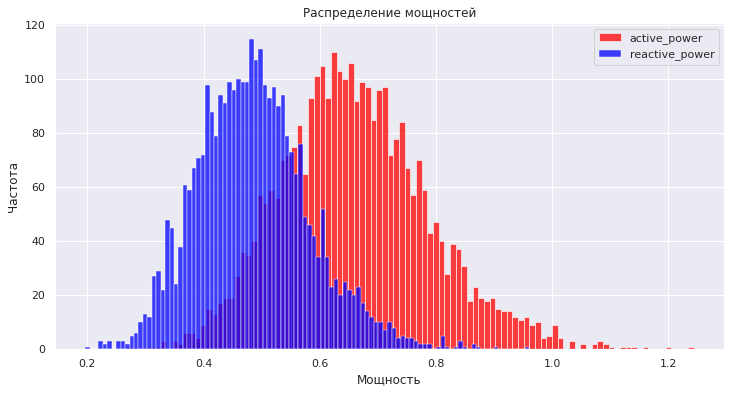

In [51]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=data_arc.groupby(by='key').mean(), x="active_power", color="red", label="active_power", bins=100)
sns.histplot(data=data_arc.groupby(by='key').mean(), x="reactive_power", color="blue", label="reactive_power", bins=100)

plt.ylabel('Частота')
plt.xlabel('Мощность')
plt.title('Распределение мощностей')
plt.legend() 
plt.show()

Распределения мощностей выглядят похожим образом, только сдвинуты относительно друг друга. Попробуем использовать в дальнейшем отношение этих признаков, а также полную мощность (корень квадратный из суммы квадратов активной и реактивной).

In [52]:
data_arc['sum_power'] = ((data_arc['active_power'])**2 + (data_arc['reactive_power'])**2)**0.5

In [53]:
data_arc['dif_power'] = data_arc['active_power']/data_arc['reactive_power']

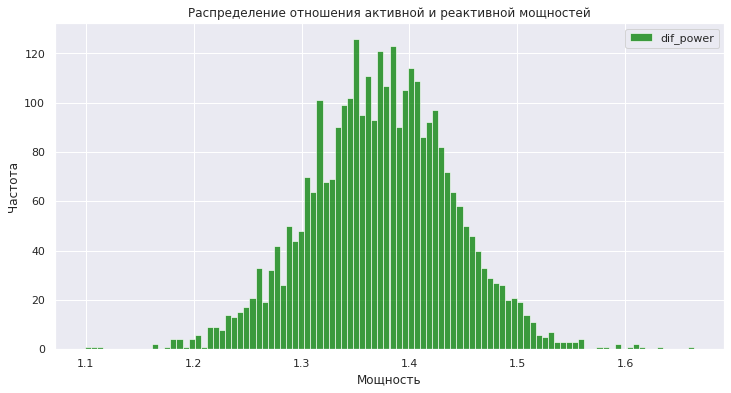

In [54]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=data_arc.groupby(by='key').mean(), x="dif_power", color="green", label="dif_power", bins=100)

plt.ylabel('Частота')
plt.xlabel('Мощность')
plt.title('Распределение отношения активной и реактивной мощностей')
plt.legend() 
plt.show()

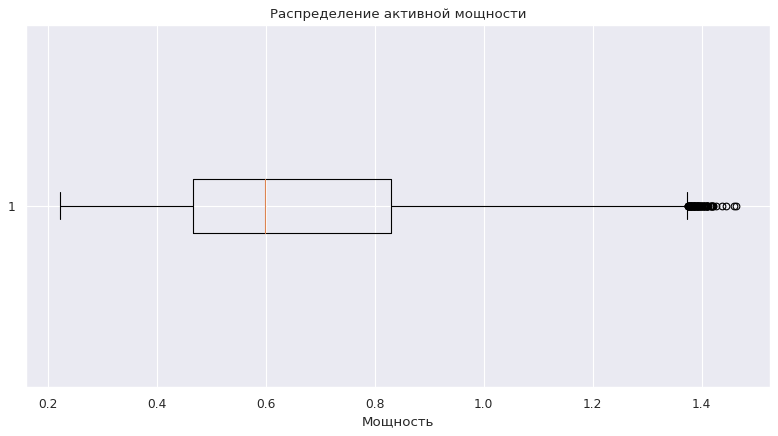

In [55]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(data_arc['active_power'], vert=False)
plt.title('Распределение активной мощности')
plt.xlabel('Мощность')
plt.show()

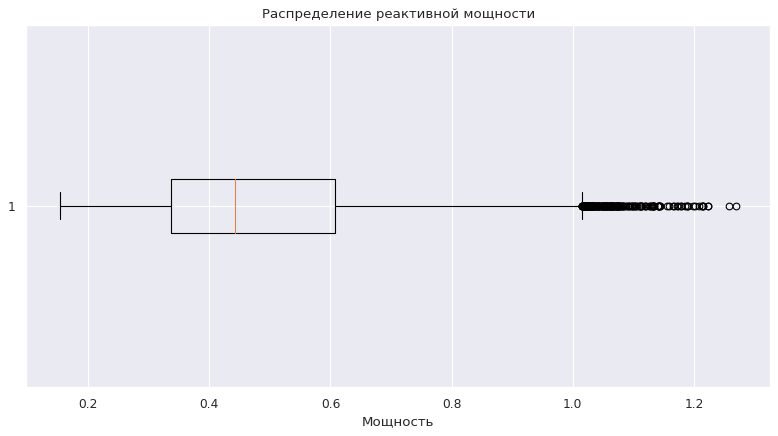

In [56]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(data_arc['reactive_power'], vert=False)
plt.title('Распределение реактивной мощности')
plt.xlabel('Мощность')
plt.show()

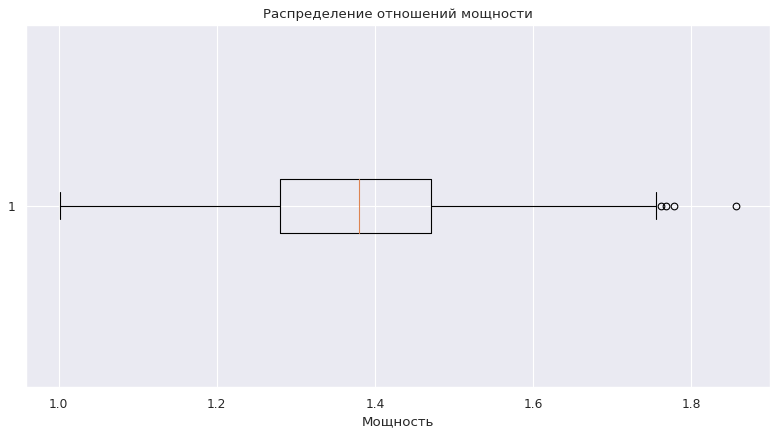

In [57]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(data_arc['dif_power'], vert=False)
plt.title('Распределение отношений мощности')
plt.xlabel('Мощность')
plt.show()

Каких-тосовсем уж неразумных выбросов в данных по мощности нет.

Времена начала и окончания нагрева, сами по себе, не имеют смысла, поэтому введем новый признак - длительность нагрева (разницу между этими временами в минутах).

In [58]:
data_arc['delta_min'] = data_arc['end_heat'] - data_arc['begin_heat']

In [59]:
data_arc['delta_min'] = data_arc['delta_min'].dt.total_seconds() / 60

In [60]:
data_arc.head()

,key,begin_heat,end_heat,active_power,reactive_power,sum_power,dif_power,delta_min
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,1.444382,3.800000
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,1.603680,3.083333
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,1.348123,2.866667
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,1.364539,6.083333
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,1.347126,2.466667


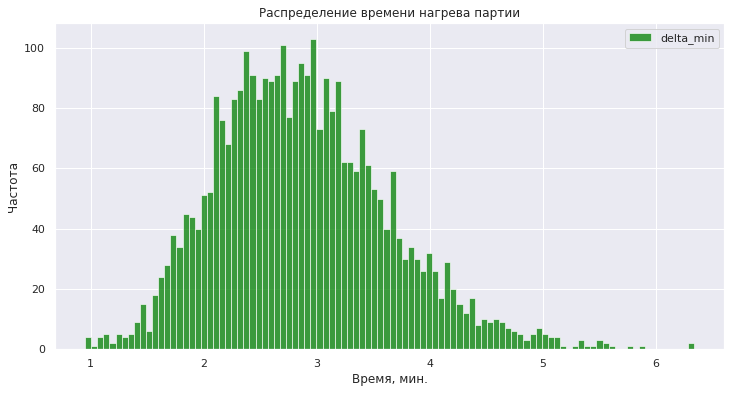

In [61]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=data_arc.groupby(by='key').mean(), x="delta_min", color="green", label="delta_min", bins=100)

plt.ylabel('Частота')
plt.xlabel('Время, мин.')
plt.title('Распределение времени нагрева партии')
plt.legend() 
plt.show()

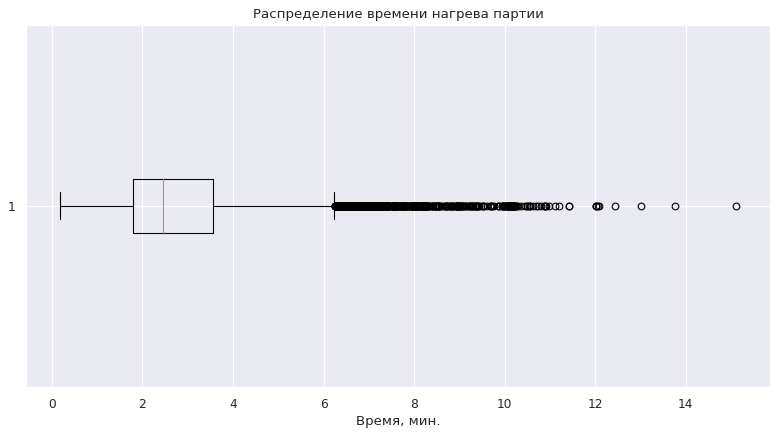

In [62]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(data_arc['delta_min'], vert=False)
plt.title('Распределение времени нагрева партии')
plt.xlabel('Время, мин.')
plt.show()

Сильно неразумных выбросов нет.

Сгруппируем данные по номеру партии и возьмем средние значения.

In [63]:
data_arc = data_arc.groupby(by='key').mean()

In [64]:
#data_arc = data_arc.drop(['active_power', 'reactive_power'], axis = 1)

In [65]:
data_arc.head()

,active_power,reactive_power,sum_power,dif_power,delta_min
key,,,,,
1,0.607346,0.428564,0.743747,1.421570,3.660000
2,0.534852,0.363339,0.647087,1.479201,3.379167
3,0.812728,0.587491,1.003845,1.396069,2.183333
4,0.676622,0.514248,0.850010,1.307446,3.087500
5,0.563238,0.421998,0.704245,1.328894,3.620833


In [66]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 1 to 3241
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   active_power    3214 non-null   float64
 1   reactive_power  3214 non-null   float64
 2   sum_power       3214 non-null   float64
 3   dif_power       3214 non-null   float64
 4   delta_min       3214 non-null   float64
dtypes: float64(5)
memory usage: 150.7 KB


# Таблица data_bulk

In [67]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


Заменим тип данных в столбцах bulk_5 - bulk_15 на float.

In [68]:
columns_to_convert = ['bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10',
                     'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15']

In [69]:
data_bulk[columns_to_convert] = data_bulk[columns_to_convert].astype(float)

In [70]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [71]:
data_bulk['key'].nunique()

3129

In [72]:
pd.DataFrame(data_bulk.isna().mean()*100)

,0
key,0.000000
bulk_1,91.946309
bulk_2,99.296900
bulk_3,58.517098
bulk_4,67.593480
bulk_5,97.539150
bulk_6,81.591563
bulk_7,99.201023
bulk_8,99.968041
bulk_9,99.392777


Заменим все пропуски 0, так как это означает, что материал просто не добавляли в партию.

In [73]:
data_bulk = data_bulk.fillna(0)

In [74]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [75]:
data_bulk.duplicated().sum()

0

Дубликатов в данных не обнаружено.

In [76]:
data_bulk.describe()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000,3129.000000
mean,1624.383509,3.160435,1.779163,47.240332,33.830617,2.633749,21.892298,2.441675,0.015660,0.463407,4.684564,4.345478,203.948226,1.041866,152.706616,115.319271
std,933.337642,11.869164,21.217878,74.239954,56.034505,20.918138,55.492582,31.944063,0.875978,6.154398,20.157323,22.699580,151.419639,14.114252,81.091421,84.488698
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,816.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,1622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,2431.000000,0.000000,0.000000,80.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Посмотрим на распределение объёмов подаваемого материала для четырех материалов с различными средними значениями объемов. bulk_1 и bulk_9 имеют очень низкие средние значения, то есть, редко и в малом количестве добавляются при выплавке. bulk_12 и bulk_15 добавляются чаще и в большем количестве.

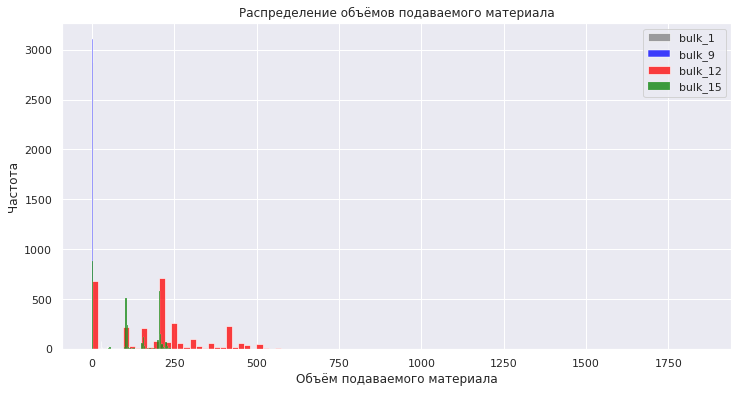

In [77]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=data_bulk, x="bulk_1", color="grey", label="bulk_1", bins=100)
sns.histplot(data=data_bulk, x="bulk_9", color="blue", label="bulk_9", bins=100)
sns.histplot(data=data_bulk, x="bulk_12", color="red", label="bulk_12", bins=100)
sns.histplot(data=data_bulk, x="bulk_15", color="green", label="bulk_15", bins=100)
plt.xlabel('Объём подаваемого материала')
plt.ylabel('Частота')
plt.title('Распределение объёмов подаваемого материала')
plt.legend() 
plt.show();

Чаще всего bulk_1 и bulk_9 вообще не используются. А те сыпучие материалы, которые используются, обычно подаются какими-то конкретными порциями.

In [78]:
bulk_columns = [col for col in data_bulk.columns if col != 'key']

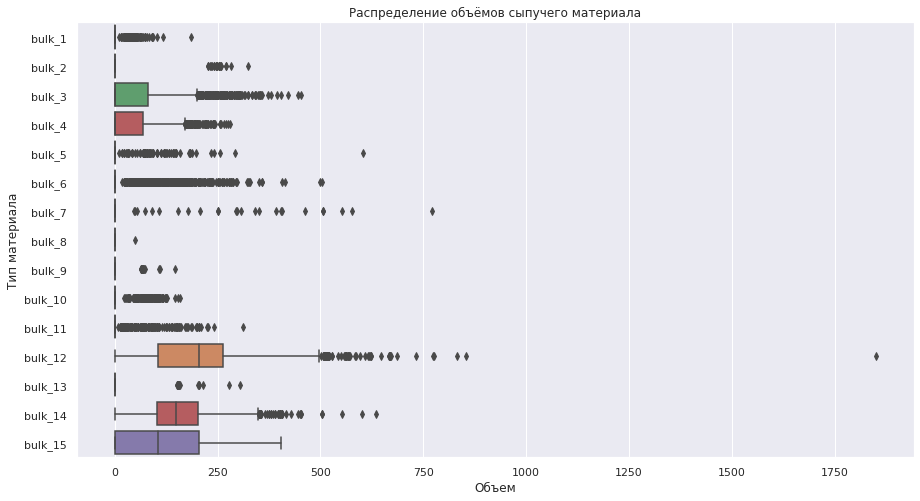

In [79]:
# Создаем длинный DataFrame

long_data = data_bulk[bulk_columns].melt(var_name='Тип материала', value_name='Объем')

# Строим боксплот по "длинным" данным

plt.figure(figsize=(15, 8))

sns.boxplot(x='Объем', y='Тип материала', data=long_data, palette='deep')

plt.title('Распределение объёмов сыпучего материала')

plt.ylabel('Тип материала')

plt.xlabel('Объем')

plt.show()

Чаще всего используются материалы bulk_12, 14, 15. Для материала bulk_12 наблюдается одиночный выброс. Уберем его.

In [80]:
data_bulk.query('bulk_12 > 1000')

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
303,322,185.0,0.0,101.0,58.0,0.0,0.0,406.0,0.0,0.0,0.0,0.0,1849.0,0.0,636.0,0.0


In [81]:
#data_bulk = data_bulk.query('bulk_12 < 1000')

Создадим случайную выборку из пяти записей и посмотрим на то, какие и сколько сыпучих материалов добавляется в каждой партии.

In [82]:
data_bulk_sample = data_bulk.sample(5)

In [83]:
data_bulk_sample

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
2720,2823,0.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136.0,0.0,198.0,136.0
1090,1138,27.0,0.0,159.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,0.0,100.0,202.0
151,165,0.0,0.0,171.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,109.0,205.0
157,171,0.0,0.0,89.0,0.0,0.0,174.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,204.0,153.0
1575,1634,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,258.0,0.0,120.0,205.0


<Figure size 864x432 with 0 Axes>

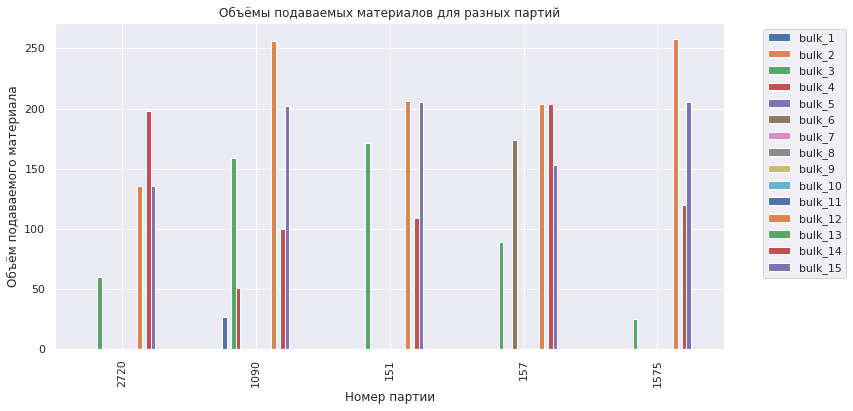

In [84]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

data_bulk_sample.drop(['key'], axis=1).plot(kind='bar', figsize=(12, 6))

plt.ylabel('Объём подаваемого материала')
plt.xlabel('Номер партии')
plt.title('Объёмы подаваемых материалов для разных партий')
plt.legend() 
plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left')
plt.show();

Из случайной выборки видно, что в каждую партию добавляется 3-5 сыпучих материала, причем некоторые материалы (в данном случае bulk_14) входят во все пять партий, а другие материалы входят в сплав значительно реже.

# Таблица data_bulk_time

In [85]:
data_bulk_time.head()

,key,t_bulk_1,t_bulk_2,t_bulk_3,t_bulk_4,t_bulk_5,t_bulk_6,t_bulk_7,t_bulk_8,t_bulk_9,t_bulk_10,t_bulk_11,t_bulk_12,t_bulk_13,t_bulk_14,t_bulk_15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


In [86]:
pd.DataFrame(data_bulk_time.isna().mean()*100)

,0
key,0.000000
t_bulk_1,91.946309
t_bulk_2,99.296900
t_bulk_3,58.517098
t_bulk_4,67.593480
t_bulk_5,97.539150
t_bulk_6,81.591563
t_bulk_7,99.201023
t_bulk_8,99.968041
t_bulk_9,99.392777


В таблице довольно много пропусков, что связано с тем, что данный материал не добавляли в сталь.

In [87]:
data_bulk_time.duplicated().sum()

0

Дубликатов в данных не обнаружено.

Заменим формат даты на datetime.

In [88]:
bulk_time_columns = [col for col in data_bulk_time.columns if col != 'key']

In [89]:
data_bulk_time[bulk_time_columns] = data_bulk_time[bulk_time_columns].apply(lambda x: pd.to_datetime(x, errors='coerce'))

In [90]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   key        3129 non-null   int64         
 1   t_bulk_1   252 non-null    datetime64[ns]
 2   t_bulk_2   22 non-null     datetime64[ns]
 3   t_bulk_3   1298 non-null   datetime64[ns]
 4   t_bulk_4   1014 non-null   datetime64[ns]
 5   t_bulk_5   77 non-null     datetime64[ns]
 6   t_bulk_6   576 non-null    datetime64[ns]
 7   t_bulk_7   25 non-null     datetime64[ns]
 8   t_bulk_8   1 non-null      datetime64[ns]
 9   t_bulk_9   19 non-null     datetime64[ns]
 10  t_bulk_10  176 non-null    datetime64[ns]
 11  t_bulk_11  177 non-null    datetime64[ns]
 12  t_bulk_12  2450 non-null   datetime64[ns]
 13  t_bulk_13  18 non-null     datetime64[ns]
 14  t_bulk_14  2806 non-null   datetime64[ns]
 15  t_bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usa

Создадим новый признак max_min_diff (в минутах), показывающий разницу по времени между самым поздним добавлением материала и самым ранним.

In [91]:
# Создаём новую колонку с разницей между максимумом и минимумом по выбранным колонкам
data_bulk_time['max_min_diff'] = data_bulk_time[bulk_time_columns].max(axis=1) - data_bulk_time[bulk_time_columns].min(axis=1)

In [92]:
data_bulk_time['max_min_diff'] = data_bulk_time['max_min_diff'].dt.total_seconds() / 60

In [93]:
data_bulk_time_new = data_bulk_time.drop(bulk_time_columns, axis = 1)

In [94]:
data_bulk_time_new.head()

,key,max_min_diff
0,1,18.083333
1,2,16.666667
2,3,16.383333
3,4,14.633333
4,5,3.416667


In [95]:
pd.DataFrame(data_bulk_time_new.isna().mean()*100)

,0
key,0.0
max_min_diff,0.0


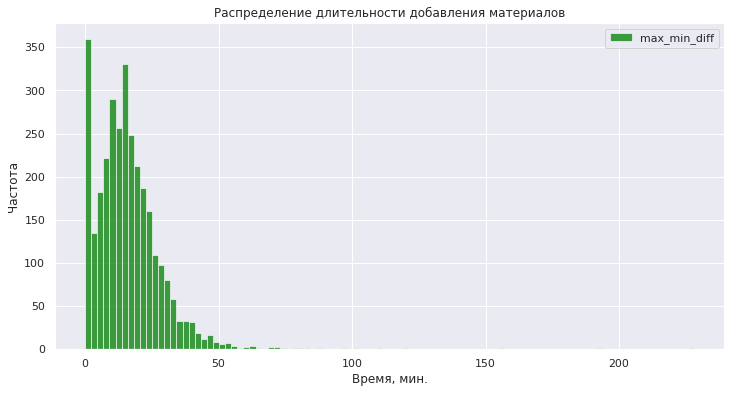

In [96]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=data_bulk_time_new, x="max_min_diff", color="green", label="max_min_diff", bins=100)

plt.ylabel('Частота')
plt.xlabel('Время, мин.')
plt.title('Распределение длительности добавления материалов')
plt.legend() 
plt.show()

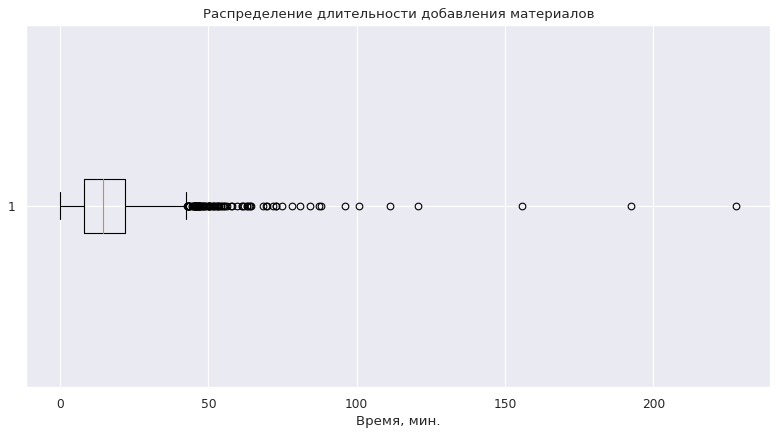

In [97]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(data_bulk_time_new['max_min_diff'], vert=False)
plt.title('Распределение длительности добавления материалов')
plt.xlabel('Время, мин.')
plt.show()

Из графиков видно, что очень часто, но не всегда, в сталь добавляют только один сыпучий матерал (высокий столбик в нуле). Аномалий по времени не обнаружено.

In [98]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           3129 non-null   int64  
 1   max_min_diff  3129 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.0 KB


<div class="alert alert-success" style="border-color: green; border-radius: 5px">
    <p><u><b>✅ КОММЕНТАРИЙ МЕНТОРА</b></u></p>
    <p>новый фактор, ок</p>
</div>

# Таблица data_gas

In [99]:
data_gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [100]:
pd.DataFrame(data_gas.isna().mean()*100)

,0
key,0.0
gas,0.0


In [101]:
data_gas.duplicated().sum()

0

Пропусков и дубликатов в данных не обнаружено.

In [102]:
data_gas['key'].nunique()

3239

In [103]:
len(data_gas['key'])

3239

Строк с одинаковым номером партии, но разным объемом подаваемого газа - нет.

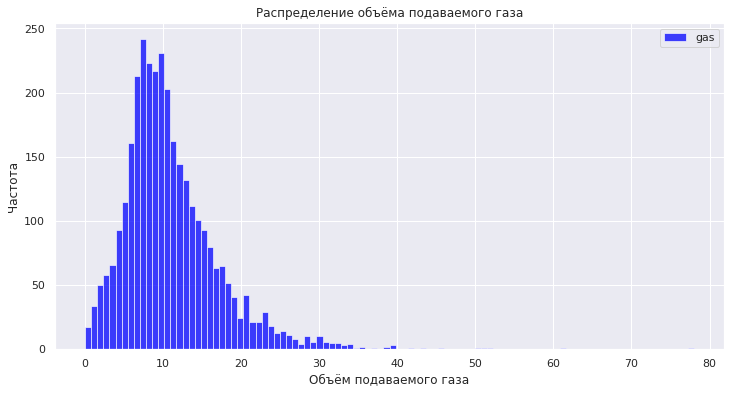

In [104]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=data_gas, x="gas", color="blue", label="gas", bins=100)

plt.ylabel('Частота')
plt.xlabel('Объём подаваемого газа')
plt.title('Распределение объёма подаваемого газа')
plt.legend() 
plt.show()

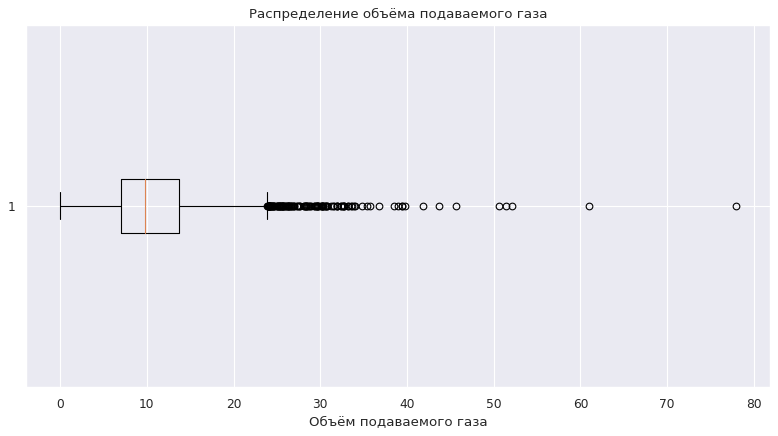

In [105]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(data_gas['gas'], vert=False)
plt.title('Распределение объёма подаваемого газа')
plt.xlabel('Объём подаваемого газа')
plt.show()

Есть небольшое количество выбросов,но они в 4-8 раз выше медианного значения, поэтому, наверное, такое действительно может быть. Не будем их выкидывать.

# Таблица data_temp

In [106]:
data_temp.head()

,key,mesaure_time,temperature
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [107]:
pd.DataFrame(data_temp.isna().mean()*100)

,0
key,0.000000
mesaure_time,0.000000
temperature,18.942074


Есть 19% пропусков параметра - температуры.

Поменяем тип данных для температуры на float, для дат - на datetime.

In [108]:
data_temp['temperature'] = data_temp['temperature'].astype(float)

In [109]:
data_temp['mesaure_time'] = pd.to_datetime(data_temp['mesaure_time'])

In [110]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   mesaure_time  18092 non-null  datetime64[ns]
 2   temperature   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


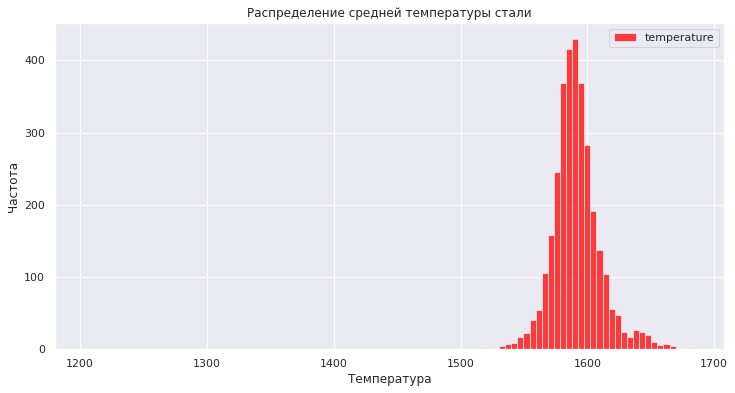

In [111]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=data_temp.groupby(by='key').mean(), x="temperature", color="red", label="temperature", bins=100)

plt.ylabel('Частота')
plt.xlabel('Температура')
plt.title('Распределение средней температуры стали')
plt.legend() 
plt.show()

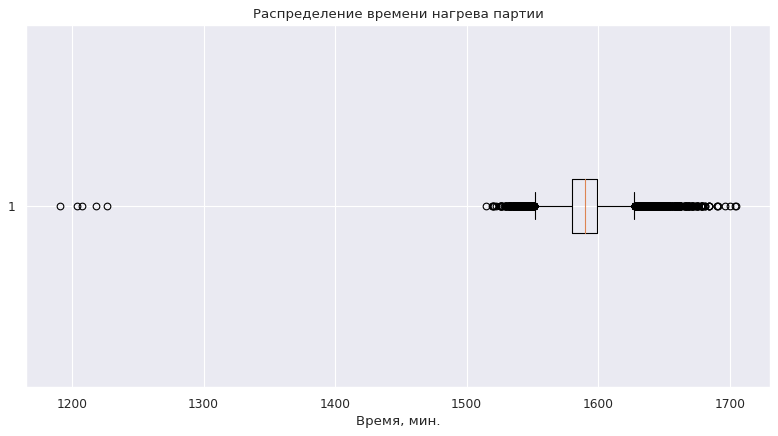

In [112]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(data_temp['temperature'].dropna(), vert=False)
plt.title('Распределение времени нагрева партии')
plt.xlabel('Время, мин.')
plt.show()

Поскольку по условию задачи значения температуры ниже 1500 градусов — аномальные, удалим эти строки.

In [113]:
data_temp = data_temp.query('temperature > 1500')

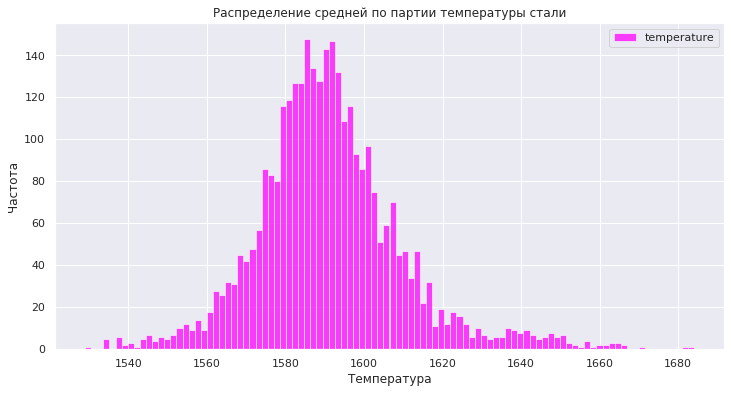

In [114]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=data_temp.groupby(by='key').mean(), x="temperature", color="magenta", label="temperature", bins=100)

plt.ylabel('Частота')
plt.xlabel('Температура')
plt.title('Распределение средней по партии температуры стали')
plt.legend() 
plt.show()

Распределение средней измеренной температуры стали - симметричное. Температура варьируется в небольших пределах +- 50 градусов.

Посмотрим на то, как делались замеры температуры в пределах одной партии для партий 1-5 и партий 1000-1004.

In [115]:
data_temp_short = data_temp.query('key == 1 or key == 2 or key == 3 or key == 4 or key == 5')

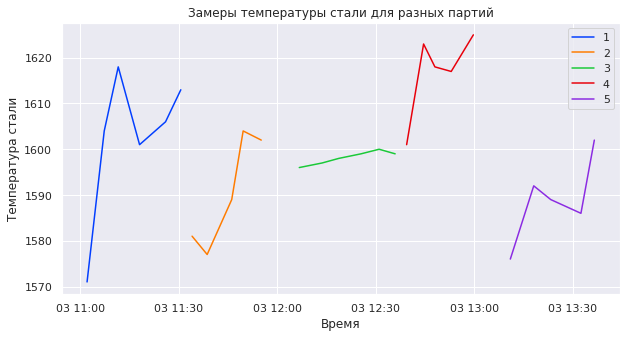

In [116]:
plt.figure(figsize=(10,5))

sns.set_theme(style="darkgrid")

sns.lineplot(x='mesaure_time', y='temperature', data=data_temp_short, hue='key', palette='bright')

plt.ylabel('Температура стали')

plt.xlabel('Время')

plt.title('Замеры температуры стали для разных партий')

plt.legend()

plt.show();

In [117]:
data_temp_short_1 = data_temp.query('key == 1000 or key == 1001 or key == 1002 or key == 1003 or key == 1004')

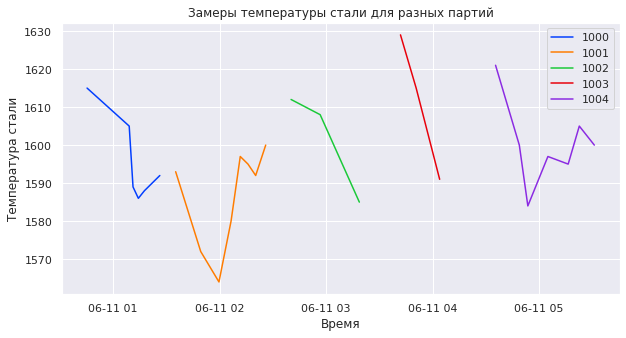

In [118]:
plt.figure(figsize=(10,5))

sns.set_theme(style="darkgrid")

sns.lineplot(x='mesaure_time', y='temperature', data=data_temp_short_1, hue='key', palette='bright')

plt.ylabel('Температура стали')

plt.xlabel('Время')

plt.title('Замеры температуры стали для разных партий')

plt.legend()

plt.show();

Видно, что для разных партий стали есть серия замеров температур в разные моменты времени. Количество замеров и интервалы между ними могут быть разными. Соответственно, характер изменения температуры стали может быть разным.

По условию задачи: целевой признак — последняя температура партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать как входные.

Создадим новый датафрейм, в который войдут номер партии, начальная и последняя темепратуры стали, число замеров температуры (num_unique_time), а также время между самым поздним и самым ранним замерами температуры (delta_masure в минутах).

In [119]:
key_list = data_temp['key'].unique()

In [120]:
print(key_list)

[   1    2    3 ... 3239 3240 3241]


In [121]:
data_temp['key'].nunique()

3215

In [122]:
data_temp.query('key == 5')

,key,mesaure_time,temperature
22,5,2019-05-03 13:11:03,1576.0
23,5,2019-05-03 13:18:11,1592.0
24,5,2019-05-03 13:23:22,1589.0
25,5,2019-05-03 13:32:34,1586.0
26,5,2019-05-03 13:36:39,1602.0


In [123]:
# Группируем по 'номеру партии'

grouped = data_temp.groupby('key')

# Находим строки с минимальным временем для каждого номера

min_time_rows = grouped.apply(lambda x: x.loc[x['mesaure_time'].idxmin()]).reset_index(drop=True)

# Находим строки с максимальным временем для каждого номера

max_time_rows = grouped.apply(lambda x: x.loc[x['mesaure_time'].idxmax()]).reset_index(drop=True)

# Создаем новую таблицу, объединяя эти данные

temp_result = pd.DataFrame({

    'key': min_time_rows['key'],

    'temperatute_first': min_time_rows['temperature'].values,

    'temperature_target': max_time_rows['temperature'].values,
    
    'delta_measure': (max_time_rows['mesaure_time'] - min_time_rows['mesaure_time']).dt.total_seconds() / 60,
    
    'num_unique_time': grouped['mesaure_time'].nunique().reset_index(drop=True)

})

In [124]:
temp_result.head()

,key,temperatute_first,temperature_target,delta_measure,num_unique_time
0,1,1571.0,1613.0,28.566667,6
1,2,1581.0,1602.0,21.083333,5
2,3,1596.0,1599.0,29.216667,6
3,4,1601.0,1625.0,20.333333,5
4,5,1576.0,1602.0,25.600000,5


In [125]:
temp_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3215 entries, 0 to 3214
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 3215 non-null   int64  
 1   temperatute_first   3215 non-null   float64
 2   temperature_target  3215 non-null   float64
 3   delta_measure       3215 non-null   float64
 4   num_unique_time     3215 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 125.7 KB


In [126]:
pd.DataFrame(temp_result.isna().mean()*100)

,0
key,0.0
temperatute_first,0.0
temperature_target,0.0
delta_measure,0.0
num_unique_time,0.0


In [127]:
temp_result.query('temperatute_first == temperature_target')

,key,temperatute_first,temperature_target,delta_measure,num_unique_time
60,63,1580.0,1580.0,31.583333,5
192,195,1583.0,1583.0,0.000000,1
194,197,1582.0,1582.0,13.400000,4
259,262,1596.0,1596.0,58.616667,7
276,279,1603.0,1603.0,0.000000,1
...,...,...,...,...,...
3210,3237,1569.0,1569.0,0.000000,1
3211,3238,1584.0,1584.0,0.000000,1
3212,3239,1598.0,1598.0,0.000000,1
3213,3240,1617.0,1617.0,0.000000,1


При агрегировании наблюдений используем только ключи, у которых как минимум два наблюдения: первый и последний замеры температуры.

In [128]:
temp_result = temp_result[temp_result['delta_measure'] > 0]

In [129]:
len(temp_result.query('temperatute_first == temperature_target'))

43

В таблице имеются данные, где первая и последняя измеренные температуры, равны

# Таблица data_wire

In [130]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None


In [131]:
pd.DataFrame(data_wire.isna().mean()*100)

,0
key,0.000000
wire_1,0.843882
wire_2,64.978903
wire_3,97.955209
wire_4,99.545602
wire_5,99.967543
wire_6,97.630639
wire_7,99.642973
wire_8,99.383317
wire_9,99.058747


Заменим все пропуски 0, так как это означает, что материал просто не добавляли в партию.

In [132]:
data_wire = data_wire.fillna(0)

In [133]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,0,0,0,0,0,0,0,0
1,2,96.052315,0,0,0,0,0,0,0,0
2,3,91.160157,0,0,0,0,0,0,0,0
3,4,89.063515,0,0,0,0,0,0,0,0
4,5,89.238236,9.11456,0,0,0,0,0,0,0


In [134]:
wire_columns = [col for col in data_wire.columns if col != 'key']

In [135]:
data_wire[wire_columns] = data_wire[wire_columns].astype(float)

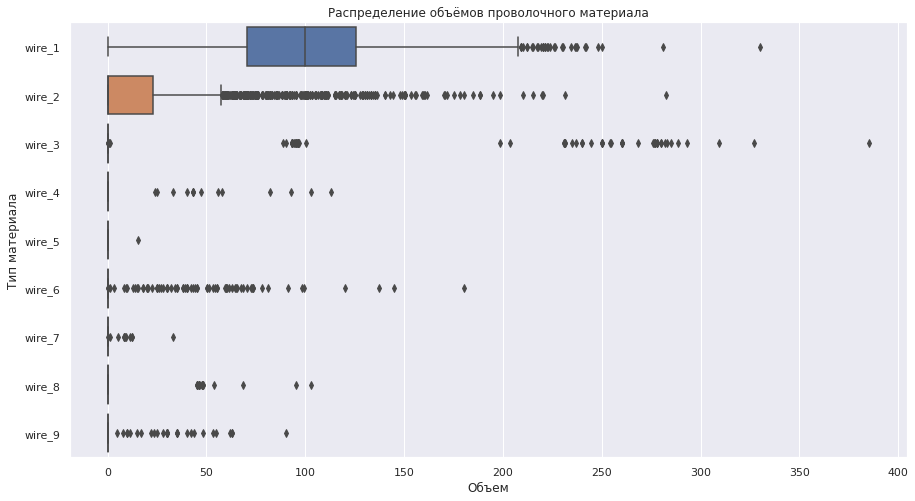

In [136]:
# Создаем длинный DataFrame

long_data = data_wire[wire_columns].melt(var_name='Тип материала', value_name='Объем')

# Строим боксплот по "длинным" данным

plt.figure(figsize=(15, 8))

sns.boxplot(x='Объем', y='Тип материала', data=long_data, palette='deep')

plt.title('Распределение объёмов проволочного материала')

plt.ylabel('Тип материала')

plt.xlabel('Объем')

plt.show()

In [137]:
data_wire_sample = data_wire.sample(5)

<Figure size 864x432 with 0 Axes>

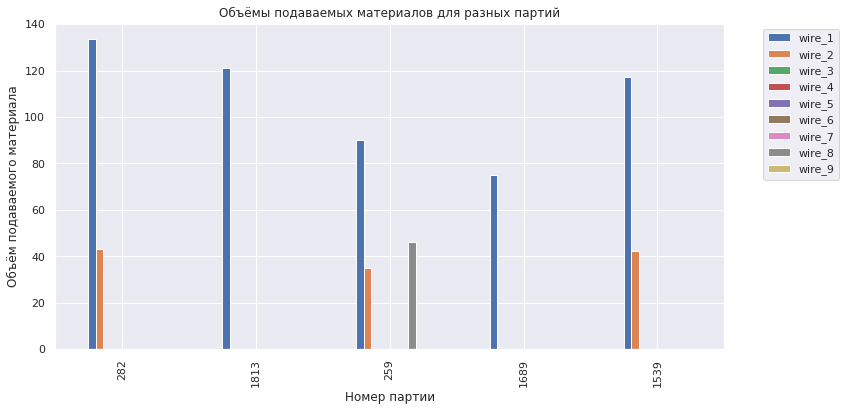

In [138]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

data_wire_sample.drop(['key'], axis=1).plot(kind='bar', figsize=(12, 6))

plt.ylabel('Объём подаваемого материала')
plt.xlabel('Номер партии')
plt.title('Объёмы подаваемых материалов для разных партий')
plt.legend() 
plt.legend(bbox_to_anchor = (1.05, 1), loc='upper left')
plt.show();

Из графиков видно, что в отличие от сыпучих материалов, вариантов подачи проволочных материалов значительно меньше. В большинстве случаев подается материал wire_1.

# Таблица data_wire_time

In [139]:
data_wire_time.head()

,key,t_wire_1,t_wire_2,t_wire_3,t_wire_4,t_wire_5,t_wire_6,t_wire_7,t_wire_8,t_wire_9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None


In [140]:
pd.DataFrame(data_wire_time.isna().mean()*100)

,0
key,0.000000
t_wire_1,0.843882
t_wire_2,64.978903
t_wire_3,97.955209
t_wire_4,99.545602
t_wire_5,99.967543
t_wire_6,97.630639
t_wire_7,99.642973
t_wire_8,99.383317
t_wire_9,99.058747


Пропусков довольно много, это связано с тем, что данный материал просто не добавлялся при выплавке стали.

In [141]:
data_wire_time.duplicated().sum()

0

Дубликатов не обнаружено.

Заменим тип данных для дат на datetime.

In [142]:
wire_time_columns = [col for col in data_wire_time.columns if col != 'key']

In [143]:
data_wire_time[wire_time_columns] = data_wire_time[wire_time_columns].apply(lambda x: pd.to_datetime(x, errors='coerce'))

In [144]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   key       3081 non-null   int64         
 1   t_wire_1  3055 non-null   datetime64[ns]
 2   t_wire_2  1079 non-null   datetime64[ns]
 3   t_wire_3  63 non-null     datetime64[ns]
 4   t_wire_4  14 non-null     datetime64[ns]
 5   t_wire_5  1 non-null      datetime64[ns]
 6   t_wire_6  73 non-null     datetime64[ns]
 7   t_wire_7  11 non-null     datetime64[ns]
 8   t_wire_8  19 non-null     datetime64[ns]
 9   t_wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


Как и для таблицы с веменами добаавок сыпучих материалов, введем для этой таблицы новый признак max_min_diff_w (в минутах), показывающий разницу между самым поздним и самым ранним добавлением проволочных материалов.

In [145]:
# Создаём новую колонку с разницей между максимумом и минимумом по выбранным колонкам
data_wire_time['max_min_diff_w'] = data_wire_time[wire_time_columns].max(axis=1) - data_wire_time[wire_time_columns].min(axis=1)

In [146]:
data_wire_time['max_min_diff_w'] = data_wire_time['max_min_diff_w'].dt.total_seconds() / 60

In [147]:
data_wire_time_new = data_wire_time.drop(wire_time_columns, axis = 1)

In [148]:
data_wire_time_new.head()

,key,max_min_diff_w
0,1,0.000000
1,2,0.000000
2,3,0.000000
3,4,0.000000
4,5,5.166667


In [149]:
pd.DataFrame(data_wire_time_new.isna().mean()*100)

,0
key,0.0
max_min_diff_w,0.0


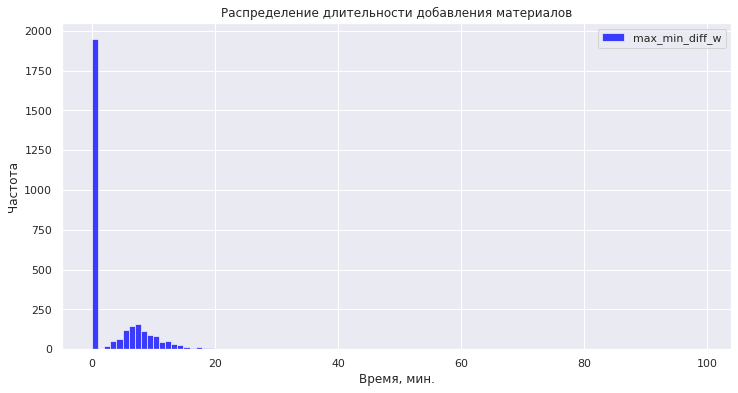

In [150]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=data_wire_time_new, x="max_min_diff_w", color="blue", label="max_min_diff_w", bins=100)

plt.ylabel('Частота')
plt.xlabel('Время, мин.')
plt.title('Распределение длительности добавления материалов')
plt.legend() 
plt.show()

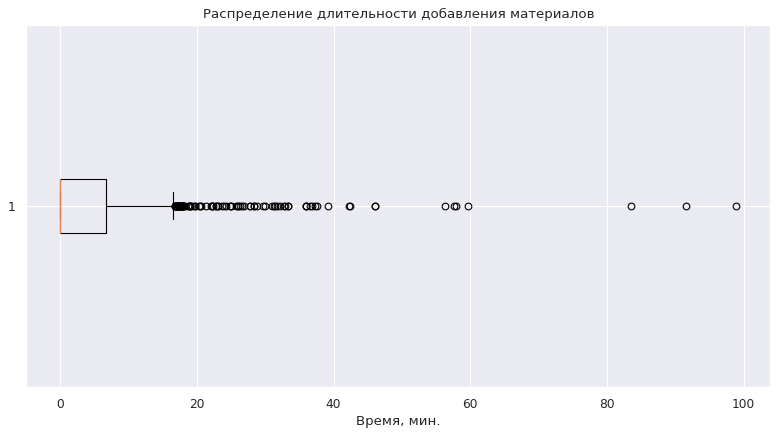

In [151]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(data_wire_time_new['max_min_diff_w'], vert=False)
plt.title('Распределение длительности добавления материалов')
plt.xlabel('Время, мин.')
plt.show()

Из графиков видно, что в сталь преимущественно добавляют только один проволочный материал. Аномалий по времени не обнаружено.

<a id='3'></a>
## Объединение таблиц

Поскольку в каждой таблице присутствует разное количество партий, сделаем внутреннее объединение всех таблиц по номеру партии.

In [152]:
result_table = data_arc.merge(data_bulk, on='key', how='inner')\
.merge(data_bulk_time_new, on='key', how='inner')\
.merge(data_gas, on='key', how='inner')\
.merge(temp_result, on='key', how='inner')\
.merge(data_wire, on='key', how='inner')\
.merge(data_wire_time_new, on='key', how='inner')

In [153]:
result_table.head()

,key,active_power,reactive_power,sum_power,dif_power,delta_min,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,max_min_diff,gas,temperatute_first,temperature_target,delta_measure,num_unique_time,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,max_min_diff_w
0,1,0.607346,0.428564,0.743747,1.421570,3.660000,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,18.083333,29.749986,1571.0,1613.0,28.566667,6,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,2,0.534852,0.363339,0.647087,1.479201,3.379167,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,16.666667,12.555561,1581.0,1602.0,21.083333,5,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,3,0.812728,0.587491,1.003845,1.396069,2.183333,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,16.383333,28.554793,1596.0,1599.0,29.216667,6,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,4,0.676622,0.514248,0.850010,1.307446,3.087500,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,14.633333,18.841219,1601.0,1625.0,20.333333,5,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,5,0.563238,0.421998,0.704245,1.328894,3.620833,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,3.416667,5.413692,1576.0,1602.0,25.600000,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.166667


In [154]:
result_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 0 to 2328
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   key                 2329 non-null   int64  
 1   active_power        2329 non-null   float64
 2   reactive_power      2329 non-null   float64
 3   sum_power           2329 non-null   float64
 4   dif_power           2329 non-null   float64
 5   delta_min           2329 non-null   float64
 6   bulk_1              2329 non-null   float64
 7   bulk_2              2329 non-null   float64
 8   bulk_3              2329 non-null   float64
 9   bulk_4              2329 non-null   float64
 10  bulk_5              2329 non-null   float64
 11  bulk_6              2329 non-null   float64
 12  bulk_7              2329 non-null   float64
 13  bulk_8              2329 non-null   float64
 14  bulk_9              2329 non-null   float64
 15  bulk_10             2329 non-null   float64
 16  bulk_1

# Визуализация распределения признаков

Еще раз соберем вместе распределения всех имеющихся признаков.

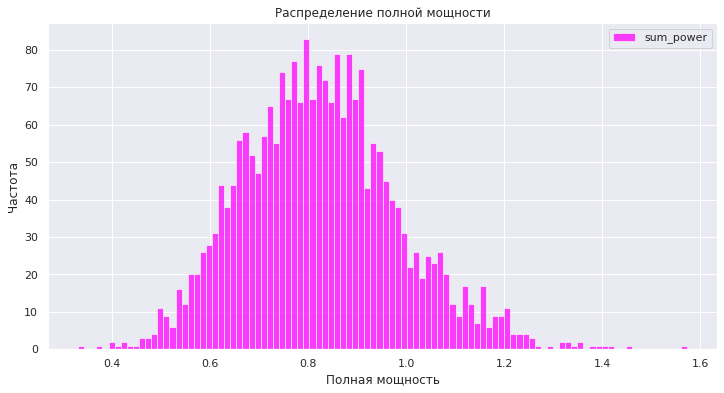

In [155]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=result_table, x="sum_power", color="magenta", label="sum_power", bins=100)

plt.ylabel('Частота')
plt.xlabel('Полная мощность')
plt.title('Распределение полной мощности')
plt.legend() 
plt.show()

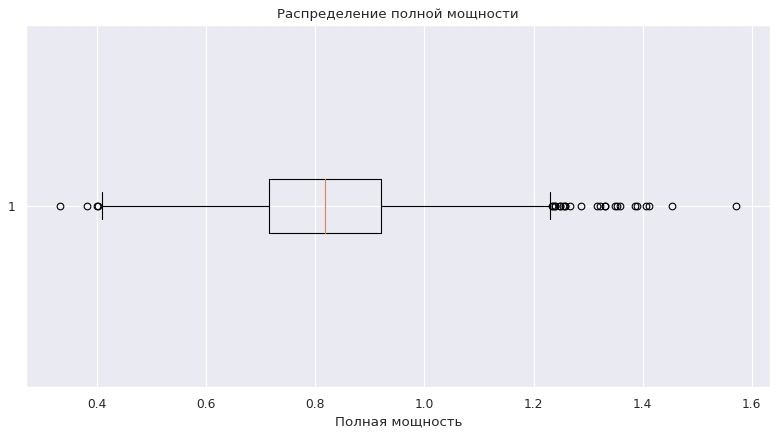

In [156]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(result_table['sum_power'], vert=False)
plt.title('Распределение полной мощности')
plt.xlabel('Полная мощность')
plt.show()

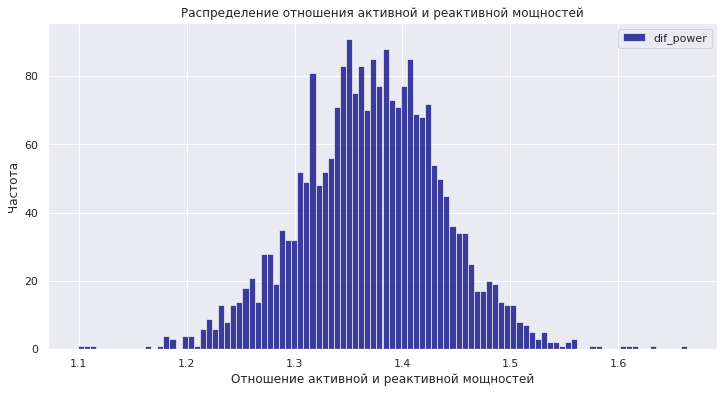

In [157]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=result_table, x="dif_power", color="navy", label="dif_power", bins=100)

plt.ylabel('Частота')
plt.xlabel('Отношение активной и реактивной мощностей')
plt.title('Распределение отношения активной и реактивной мощностей')
plt.legend() 
plt.show()

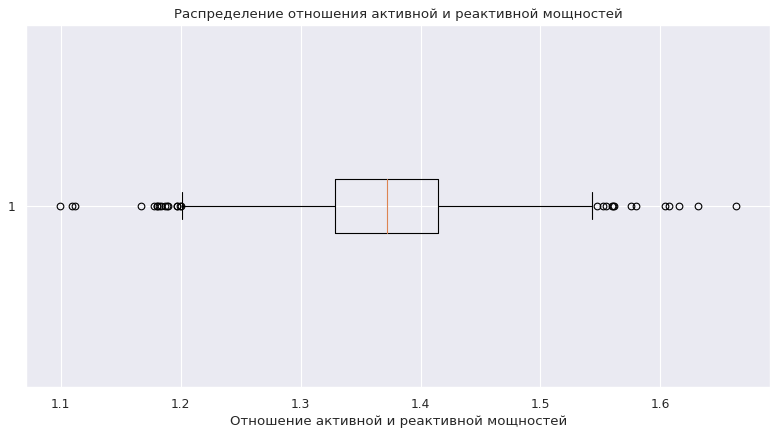

In [158]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(result_table['dif_power'], vert=False)
plt.title('Распределение отношения активной и реактивной мощностей')
plt.xlabel('Отношение активной и реактивной мощностей')
plt.show()

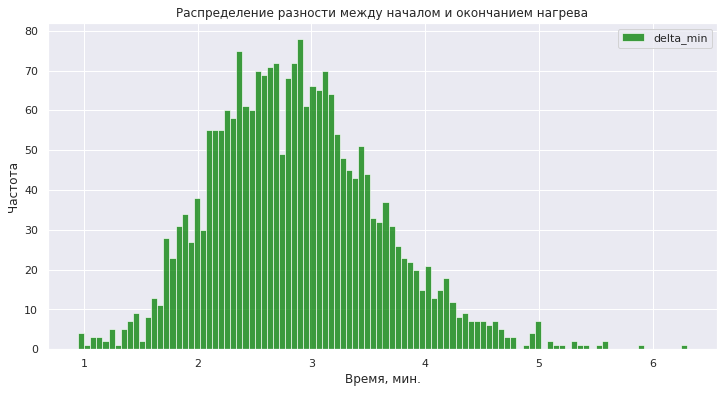

In [159]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=result_table, x="delta_min", color="green", label="delta_min", bins=100)

plt.ylabel('Частота')
plt.xlabel('Время, мин.')
plt.title('Распределение разности между началом и окончанием нагрева')
plt.legend() 
plt.show()

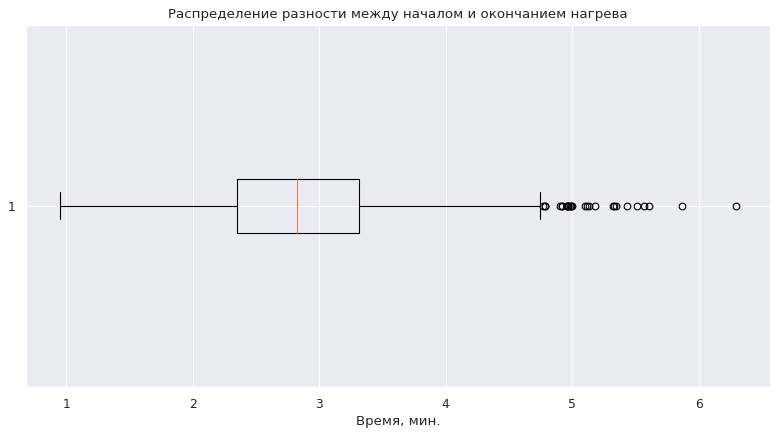

In [160]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(result_table['delta_min'], vert=False)
plt.title('Распределение разности между началом и окончанием нагрева')
plt.xlabel('Время, мин.')
plt.show()

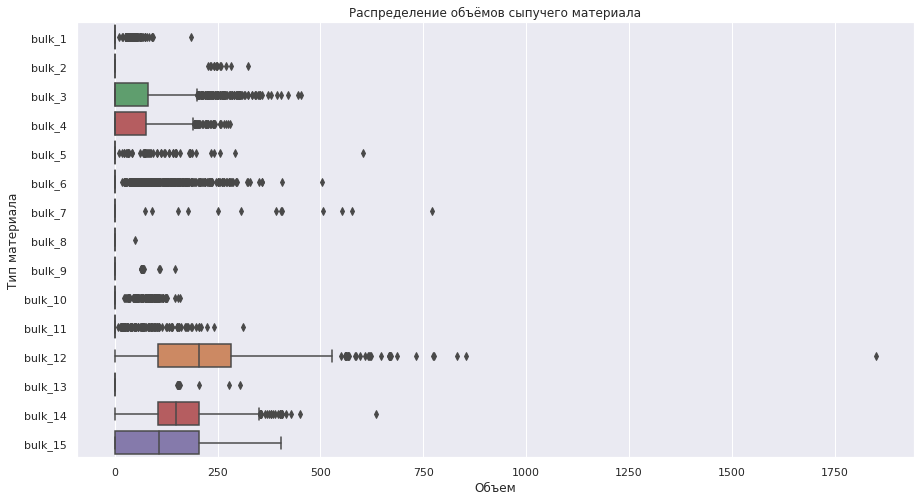

In [161]:
# Создаем длинный DataFrame

long_data = result_table[bulk_columns].melt(var_name='Тип материала', value_name='Объем')

# Строим боксплот по "длинным" данным

plt.figure(figsize=(15, 8))

sns.boxplot(x='Объем', y='Тип материала', data=long_data, palette='deep')

plt.title('Распределение объёмов сыпучего материала')

plt.ylabel('Тип материала')

plt.xlabel('Объем')

plt.show()

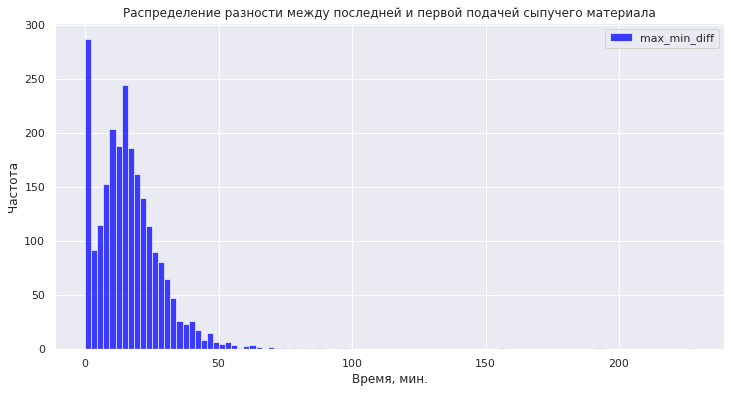

In [162]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=result_table, x="max_min_diff", color="blue", label="max_min_diff", bins=100)

plt.ylabel('Частота')
plt.xlabel('Время, мин.')
plt.title('Распределение разности между последней и первой подачей сыпучего материала')
plt.legend() 
plt.show()

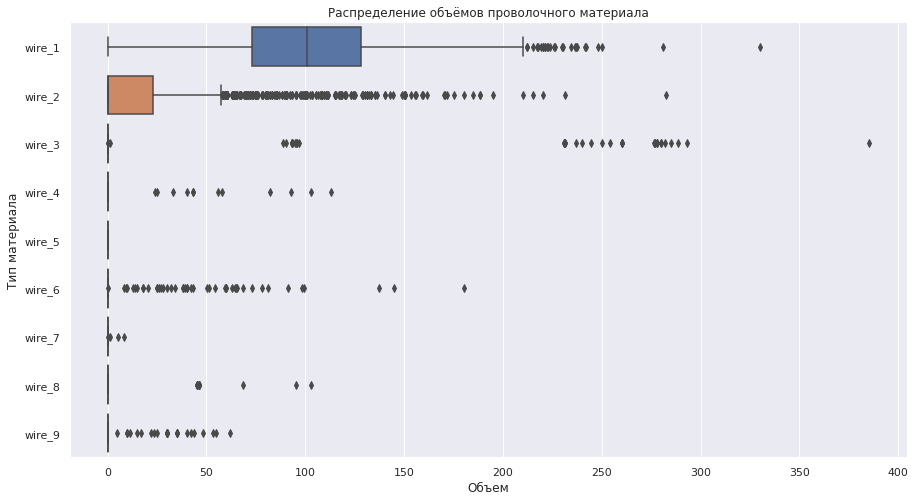

In [163]:
# Создаем длинный DataFrame

long_data = result_table[wire_columns].melt(var_name='Тип материала', value_name='Объем')

# Строим боксплот по "длинным" данным

plt.figure(figsize=(15, 8))

sns.boxplot(x='Объем', y='Тип материала', data=long_data, palette='deep')

plt.title('Распределение объёмов проволочного материала')

plt.ylabel('Тип материала')

plt.xlabel('Объем')

plt.show()

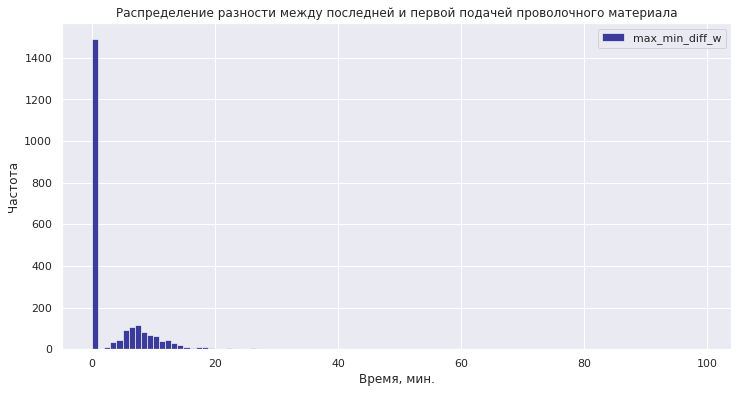

In [164]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=result_table, x="max_min_diff_w", color="navy", label="max_min_diff_w", bins=100)

plt.ylabel('Частота')
plt.xlabel('Время, мин.')
plt.title('Распределение разности между последней и первой подачей проволочного материала')
plt.legend() 
plt.show()

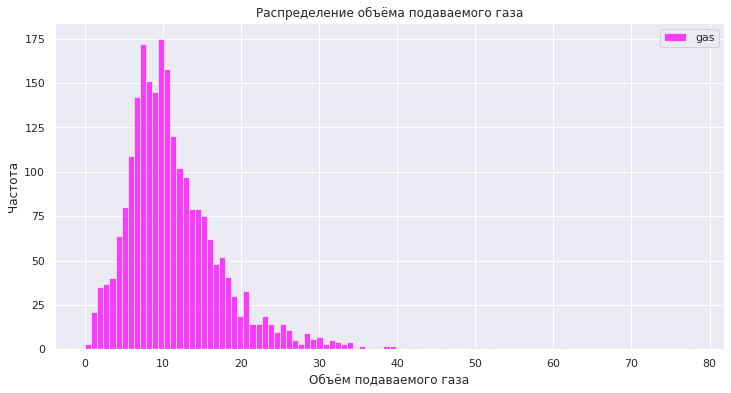

In [165]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=result_table, x="gas", color="magenta", label="gas", bins=100)

plt.ylabel('Частота')
plt.xlabel('Объём подаваемого газа')
plt.title('Распределение объёма подаваемого газа')
plt.legend() 
plt.show()

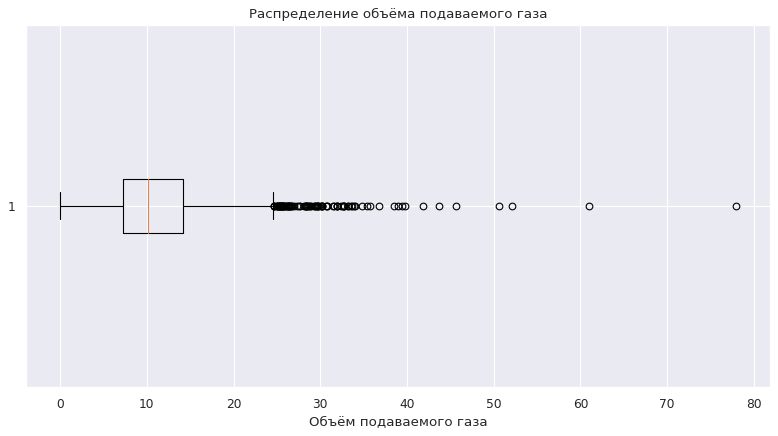

In [166]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(result_table['gas'], vert=False)
plt.title('Распределение объёма подаваемого газа')
plt.xlabel('Объём подаваемого газа')
plt.show()

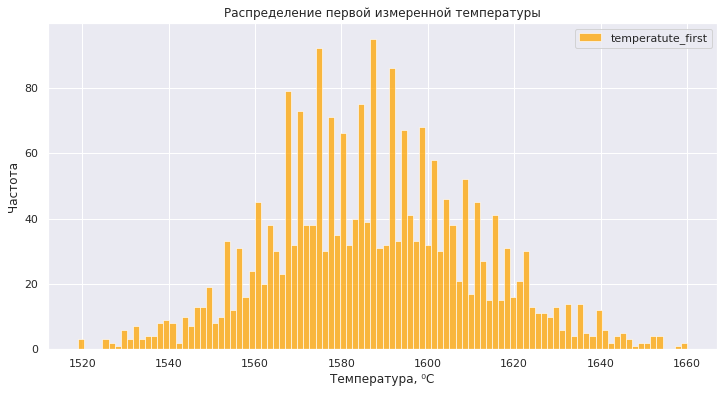

In [167]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=result_table, x="temperatute_first", color="orange", label="temperatute_first", bins=100)


plt.ylabel('Частота')
plt.xlabel('Температура, ⁰С')
plt.title('Распределение первой измеренной температуры')
plt.legend() 
plt.show()

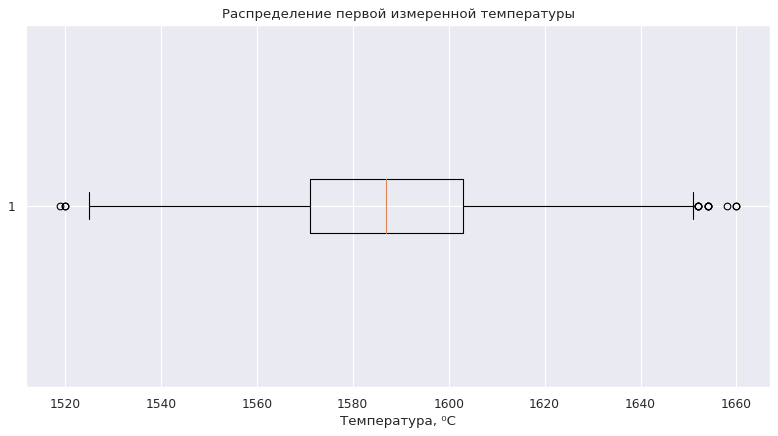

In [168]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(result_table['temperatute_first'], vert=False)
plt.title('Распределение первой измеренной температуры')
plt.xlabel('Температура, ⁰С')
plt.show()

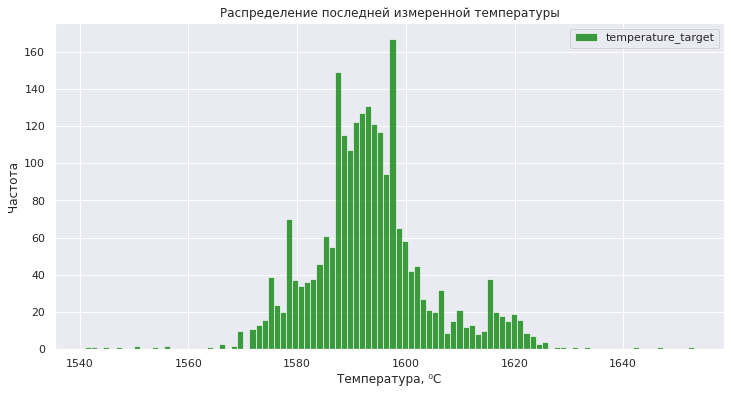

In [169]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=result_table, x="temperature_target", color="green", label="temperature_target", bins=100)

plt.ylabel('Частота')
plt.xlabel('Температура, ⁰С')
plt.title('Распределение последней измеренной температуры')
plt.legend() 
plt.show()

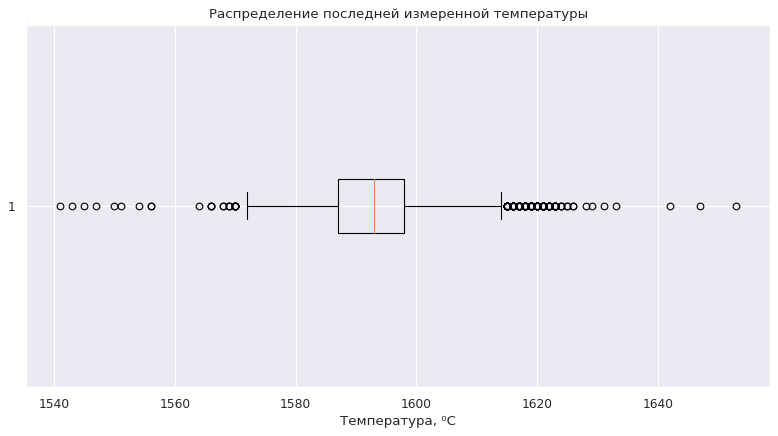

In [170]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(result_table['temperature_target'], vert=False)
plt.title('Распределение последней измеренной температуры')
plt.xlabel('Температура, ⁰С')
plt.show()

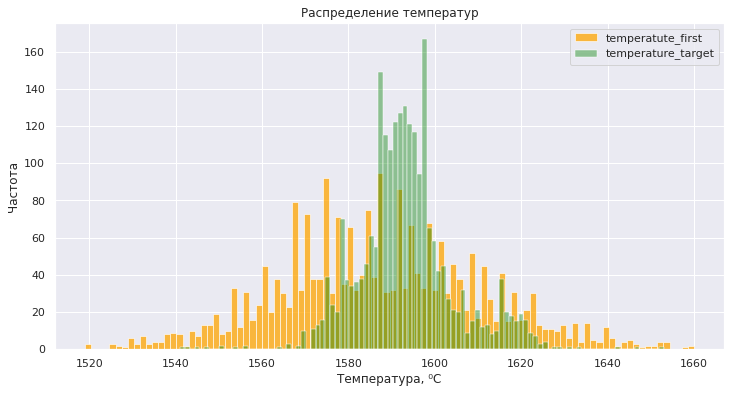

In [171]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=result_table, x="temperatute_first", color="orange", label="temperatute_first", bins=100)
sns.histplot(data=result_table, x="temperature_target", color="green", label="temperature_target", bins=100, alpha=0.4)

plt.ylabel('Частота')
plt.xlabel('Температура, ⁰С')
plt.title('Распределение температур')
plt.legend() 
plt.show()

In [172]:
result_table['temperature_target'].mean()

1593.3653928724775

In [173]:
result_table['temperature_target'].median()

1593.0

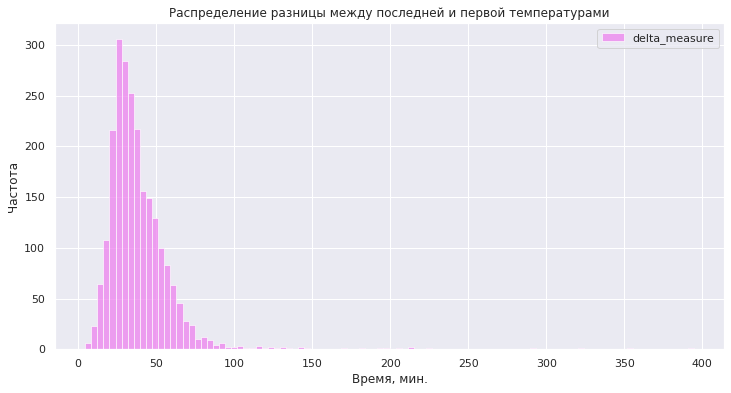

In [174]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=result_table, x="delta_measure", color="violet", label="delta_measure", bins=100)

plt.ylabel('Частота')
plt.xlabel('Время, мин.')
plt.title('Распределение разницы между последней и первой температурами')
plt.legend() 
plt.show()

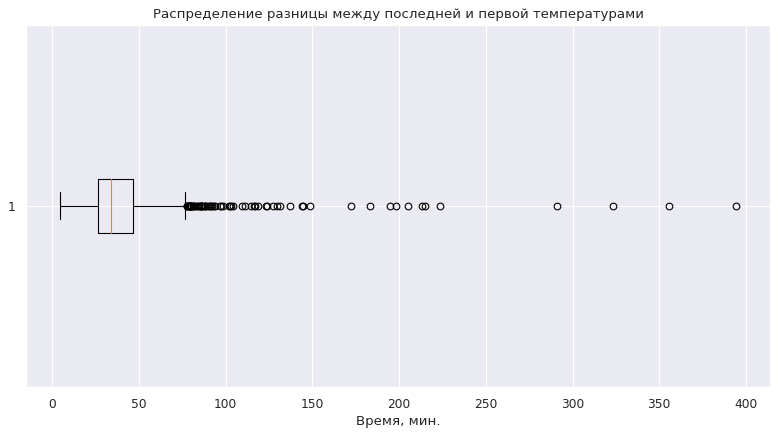

In [175]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(result_table['delta_measure'], vert=False)
plt.title('Распределение разницы между последней и первой температурами')
plt.xlabel('Время, мин.')
plt.show()

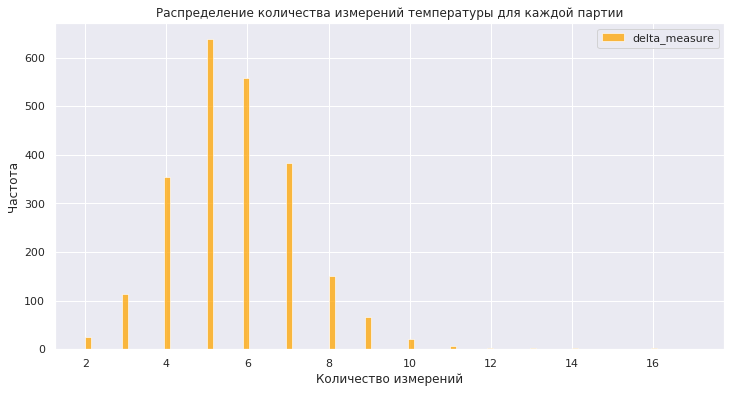

In [176]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")

sns.histplot(data=result_table, x="num_unique_time", color="orange", label="delta_measure", bins=100)

plt.ylabel('Частота')
plt.xlabel('Количество измерений')
plt.title('Распределение количества измерений температуры для каждой партии')
plt.legend() 
plt.show()

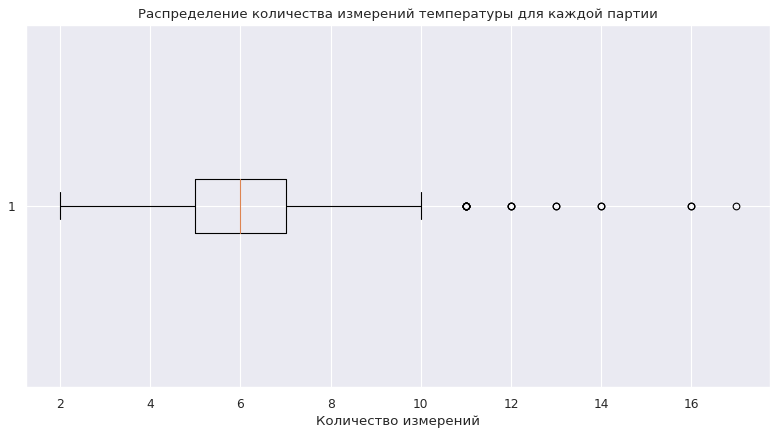

In [177]:
plt.figure(figsize=(12,6), dpi= 80)
plt.boxplot(result_table['num_unique_time'], vert=False)
plt.title('Распределение количества измерений температуры для каждой партии')
plt.xlabel('Количество измерений')
plt.show()

Поведение всех признаков кроме температур уже было описано выше.

Средняя и медианная температуры (целевого признака) примерно равны и составляют 1593 ⁰С. Распределение первой и последней температур симметричные, аномальных выбросов нет. Распределение целевой температуры более узкое, чем первой измеренной температуры. На распределениях наблюдаются многочисленные дискретные пики. То есть, какие-то дискретные температуры втречаются чаще. Не очень понятно, почему.

Чаще всего делалось по пять-шесть замеров температуры стали, но есть и партии с двумя замерами и даже с 17.

<a id='4'></a>
## Корреляционный анализ

In [178]:
num_col = [col for col in result_table.columns if col != 'key']

Для установления корреляций между целевым параметром и остальными признаками воспользуемся корреляцией Phi_K. Построим матрицу корреляций Phi_K.

In [179]:
data_phik = result_table.drop(['key'], axis=1).phik_matrix(interval_cols = num_col)
display(data_phik)

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:72: UserWarning: Not enough unique value for variable wire_5 for analysis 1. Dropping this column
  warnings.warn(


,active_power,reactive_power,sum_power,dif_power,delta_min,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,max_min_diff,gas,temperatute_first,temperature_target,delta_measure,num_unique_time,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,max_min_diff_w
active_power,1.000000,0.962644,0.994499,0.117414,0.166601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106025,0.052808,0.033984,0.000000,0.074129,0.000000,0.062149,0.000000,0.000000,0.029345,0.136461,0.000000,0.000000,0.295783,0.105846,0.167213,0.000000,0.000000,0.000000,0.000000,0.052808,0.000000,0.000000
reactive_power,0.962644,1.000000,0.980903,0.310184,0.251962,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062518,0.000000,0.000000,0.000000,0.055452,0.000000,0.000000,0.000000,0.000000,0.080521,0.073211,0.000000,0.000000,0.313737,0.041470,0.125607,0.000000,0.000000,0.000000,0.000000,0.000000,0.138877,0.000000
sum_power,0.994499,0.980903,1.000000,0.143275,0.161164,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.095383,0.032190,0.069037,0.000000,0.043173,0.000000,0.029180,0.000000,0.000000,0.096769,0.116546,0.000000,0.000000,0.317404,0.095283,0.060749,0.000000,0.000000,0.000000,0.000000,0.032190,0.000000,0.000000
dif_power,0.117414,0.310184,0.143275,1.000000,0.270880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105951,0.000000,0.000000,0.310467,0.000000,0.000000,0.000000,0.000000,0.098367,0.000000,0.000000,0.000000,0.000000
delta_min,0.166601,0.251962,0.161164,0.270880,1.000000,0.036038,0.026690,0.000000,0.147837,0.065042,0.013808,0.025643,0.000000,0.000000,0.000000,0.093212,0.323282,0.000000,0.308964,0.352089,0.074646,0.078704,0.452279,0.279890,0.071825,0.180660,0.249662,0.000000,0.000000,0.000000,0.047212,0.000000,0.000000,0.000000,0.000000
bulk_1,0.000000,0.000000,0.000000,0.000000,0.036038,1.000000,0.232997,0.000000,0.062275,0.117880,0.000000,0.495911,0.000000,0.000000,0.000000,0.000000,0.681346,0.000000,0.666508,0.042377,0.349197,0.658747,0.099145,0.180779,0.231432,0.520483,0.153110,0.247770,0.172673,0.283813,0.231768,0.259159,0.000000,0.000000,0.280171
bulk_2,0.000000,0.000000,0.000000,0.000000,0.026690,0.232997,1.000000,0.000000,0.086148,0.596870,0.000000,0.912295,0.000000,0.000000,0.000000,0.000000,0.051664,0.000000,0.164917,0.056995,0.548553,0.678496,0.217259,0.623168,0.489442,0.169764,0.284471,0.000000,0.625508,0.963955,0.815427,0.833420,0.000000,0.000000,0.668734
bulk_3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.296994,0.058609,0.293734,0.000000,0.024020,0.017979,0.000000,0.294177,0.000000,0.000000,0.060517,0.000000,0.000000,0.049219,0.123284,0.000000,0.000000,0.113177,0.288604,0.219481,0.000000,0.000000,0.072977,0.000000,0.017979,0.000000,0.000000
bulk_4,0.000000,0.000000,0.000000,0.000000,0.147837,0.062275,0.086148,0.296994,1.000000,0.129638,0.263778,0.019383,0.000000,0.051605,0.079668,0.000000,0.131923,0.000000,0.081121,0.125795,0.000000,0.033996,0.235816,0.291085,0.000000,0.018658,0.348181,0.287525,0.044396,0.049661,0.000000,0.069032,0.051605,0.000000,0.090007
bulk_5,0.000000,0.000000,0.000000,0.000000,0.065042,0.117880,0.596870,0.058609,0.129638,1.000000,0.000000,0.503916,0.000000,0.000000,0.000000,0.000000,0.071617,0.000000,0.034562,0.104811,0.222386,0.250402,0.089580,0.338418,0.303151,0.118991,0.196646,0.000000,0.430639,0.527675,0.579928,0.371586,0.000000,0.000000,0.353451


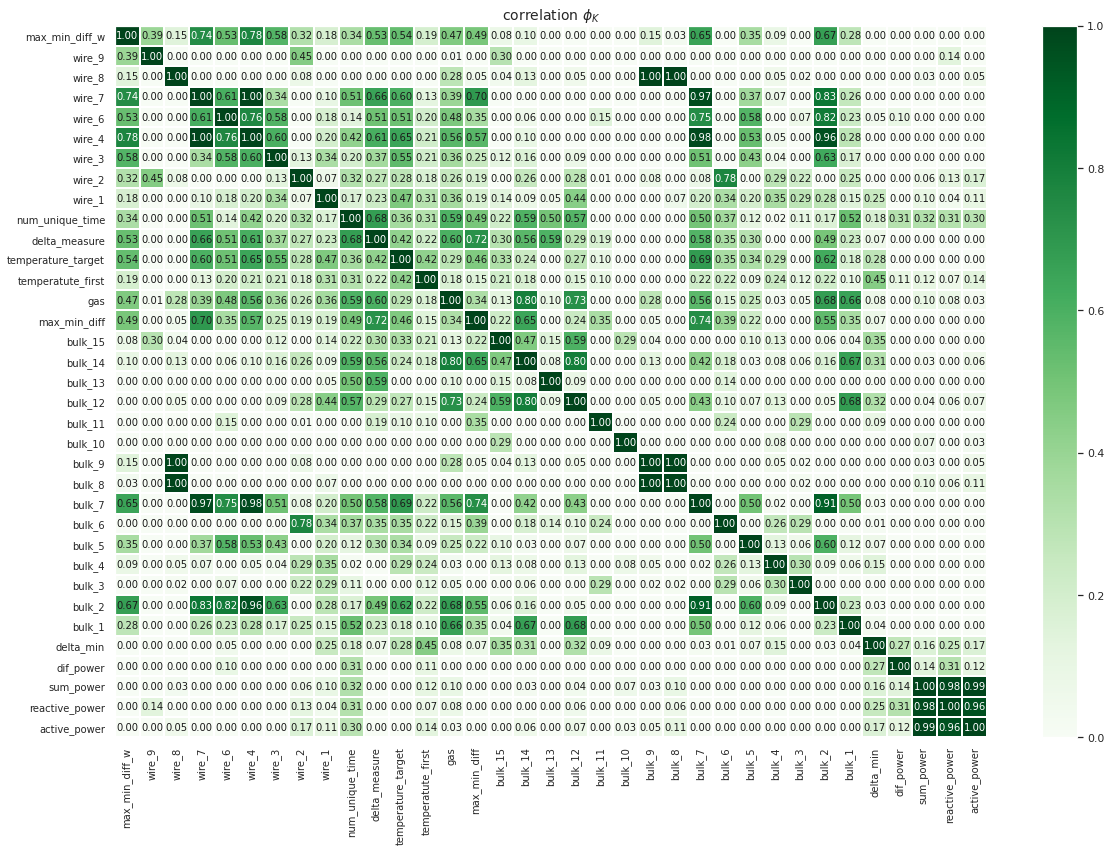

In [180]:
plot_correlation_matrix(data_phik.values, 
                        x_labels=data_phik.columns, 
                        y_labels=data_phik.index,
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(17, 12))

Из корреляционной матрицы видно, что между большинством признаков корреляция очень низкая или отсутствует. Однако между небольшим количеством признаков корреляция больше 0.9, то есть наблюдается коллинеарность. Так мультиколлинеаронсть наблюдается для некоторых признаков, относящихся к объемам добавляемых материалов. Это означает, что некоторые материалы всегда добавляют вместе (например, bulk_8 и wire8, bulk_9 и wire8). Для линейной регрессии надо было бы избавляться от таких признаков.

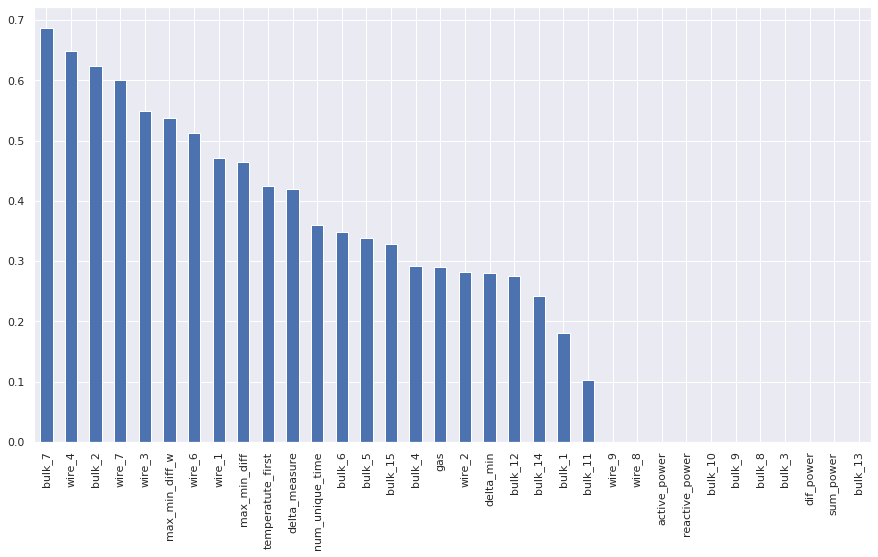

In [181]:
plt.figure(figsize=(15, 8))
_ = data_phik['temperature_target'].sort_values(ascending=False)[1:].plot(kind='bar')

Корреляционный анализ показывает, что целевой признак (temperature_target) лучше всего коррелирует с такимми признаками как bulk_7, 2; wire_4, 7, 3, max_min_df_w. Интересно, что корреляция с признаками, оносящимися к мощности - отсутствует.

<a id='5'></a>
## Обучение моделей

In [182]:
result_table.columns

Index(['key', 'active_power', 'reactive_power', 'sum_power', 'dif_power',
       'delta_min', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15', 'max_min_diff', 'gas',
       'temperatute_first', 'temperature_target', 'delta_measure',
       'num_unique_time', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5',
       'wire_6', 'wire_7', 'wire_8', 'wire_9', 'max_min_diff_w'],
      dtype='object')

In [183]:
num_col_1 = [col for col in result_table.columns if col != 'key' and col != 'temperature_target']

In [184]:
num_col_2 = ['sum_power', 'dif_power', 'delta_min', 'bulk_1', 'bulk_2', 'bulk_6', 'bulk_7',  'bulk_5',
       'bulk_3', 'bulk_4',  'bulk_12',  'bulk_14', 'bulk_15', 'bulk_10', 'bulk_11', 
       'max_min_diff', 'gas', 'temperatute_first',
       'delta_measure', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8', 'max_min_diff_w']

Разделим данные на тренировочную и тестовую выборки (test_size = 0.25).

In [185]:
Y = result_table['temperature_target']

In [186]:
X_train, X_test, y_train, y_test = train_test_split(
result_table.drop(
['temperature_target', 'key'],
axis=1
),
Y,
test_size = TEST_SIZE,
random_state = RANDOM_STATE
)

In [187]:
X_train.head()

,active_power,reactive_power,sum_power,dif_power,delta_min,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,max_min_diff,gas,temperatute_first,delta_measure,num_unique_time,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,max_min_diff_w
125,0.667367,0.475471,0.819978,1.389510,2.922222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,156.0,152.0,17.783333,10.429896,1587.0,41.883333,7,138.378241,0.000000,0.0,0.0,0.0,18.086641,0.0,0.0,0.0,3.833333
1985,0.618038,0.454423,0.768011,1.401782,2.350000,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,155.0,0.0,138.0,107.0,8.916667,4.141823,1586.0,13.066667,4,15.113280,0.000000,0.0,0.0,0.0,65.036400,0.0,0.0,0.0,3.850000
2055,0.557865,0.401782,0.687915,1.425154,2.750000,0.0,0.0,0.0,127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,332.0,0.0,195.0,194.0,14.033333,8.370165,1559.0,25.400000,6,123.177597,20.177041,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,7.266667
1954,0.666080,0.475753,0.818823,1.388309,3.169048,0.0,0.0,0.0,149.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,98.0,0.0,9.150000,14.464560,1580.0,40.900000,8,100.070877,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000
2264,0.538889,0.387570,0.664077,1.384438,4.494444,0.0,0.0,0.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,155.0,0.0,115.0,205.0,15.166667,7.203011,1548.0,19.700000,4,45.077759,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000


In [188]:
input_dim=X_train.shape[1]

In [189]:
X_train.shape

(1746, 35)

Рассмотрим следующие классы моделей:

случайный лес,
бустинг,
нейронную сеть.

По условию задачи в качестве метрики качества будем использовать MAE.

Будем выбирать лучшую модель по значению метрики на кросс-валидации.

Используем метод автоматизированного подбора гиперпараметров: RandomizedSearchCV.

In [190]:
# функция для создания модели

def create_model(units=64, input_dim=None):

    model = Sequential()

    model.add(Dense(units, activation='relu', input_shape=(input_dim,)))

    model.add(Dense(32, activation='relu'))

    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mae')

    return model

In [191]:
# обертка для использования с scikit-learn
keras_reg = KerasRegressor(build_fn=create_model, input_dim=input_dim)

/tmp/ipykernel_48/2125426870.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  keras_reg = KerasRegressor(build_fn=create_model, input_dim=input_dim)


In [192]:
num_pipe = Pipeline(
    [
        
        (
            'num', 
            StandardScaler()
        )
    ]
)

In [193]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        
        ('num', num_pipe, num_col_1)
    ] 
    #remainder='passthrough',
    
)

In [194]:
pipe_final = Pipeline([

    ('preprocessor', data_preprocessor),

    ('model', keras_reg)  # по умолчанию — keras_reg, потом будем менять

])

# Наши модели

models_list = [

    keras_reg,
    CatBoostRegressor(random_state=RANDOM_STATE, verbose=0),
    RandomForestRegressor(random_state=RANDOM_STATE)

    

]

# Параметры для каждой модели

param_grid = [
    
    # параметры для нейросети
    {

        'model': [keras_reg],
        #'models__units': [64, 128],
        'model__epochs': range(50, 100)
        #'models__batch_size': [32, 64]

    },
    
    # словарь для модели CatBoostClassifier()
    {
        
        'model': [CatBoostRegressor(random_state=RANDOM_STATE)],
        'model__depth': range(5,20),
        'model__iterations': range(500, 1000),
        'model__learning_rate': np.arange(0.001, 0.1),
         
    },
    
     # словарь для модели RandomForestRegressor()
    {

        
        'model': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': range(100, 500),
        'model__max_depth': range(20, 50),
        'model__min_samples_split': range(2, 10),
        'model__min_samples_leaf': range(1, 5),
        
    }
    
    
    
]

In [195]:
# Объединяем все параметры в один список

# (нужно, чтобы RandomizedSearchCV мог обрабатывать их)

# Для этого создадим список словарей

param_distributions = param_grid

In [196]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions=param_distributions,
    n_iter=10,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

In [197]:
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 11.2267156	total: 71.9ms	remaining: 1m 5s
1:	learn: 11.2238151	total: 87.3ms	remaining: 39.9s
2:	learn: 11.2212188	total: 101ms	remaining: 30.8s
3:	learn: 11.2184822	total: 115ms	remaining: 26.3s
4:	learn: 11.2160197	total: 130ms	remaining: 23.6s
5:	learn: 11.2129854	total: 144ms	remaining: 21.8s
6:	learn: 11.2103223	total: 157ms	remaining: 20.3s
7:	learn: 11.2074999	total: 170ms	remaining: 19.3s
8:	learn: 11.2043478	total: 184ms	remaining: 18.6s
9:	learn: 11.2021761	total: 205ms	remaining: 18.5s
10:	learn: 11.1997644	total: 227ms	remaining: 18.7s
11:	learn: 11.1967812	total: 247ms	remaining: 18.6s
12:	learn: 11.1944018	total: 262ms	remaining: 18.2s
13:	learn: 11.1916914	total: 276ms	remaining: 17.8s
14:	learn: 11.1893654	total: 292ms	remaining: 17.5s
15:	learn: 11.1865718	total: 307ms	remaining: 17.3s
16:	learn: 11.1841570	total: 321ms	remaining: 17s
17:	learn: 11.1813452	total: 335ms	remaining: 16.7s
18:	learn: 11

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('num',
                                                                                                StandardScaler())]),
                                                                               ['active_power',
                                                                                'reactive_power',
                                                                                'sum_power',
                                                                                'dif_power',
                                                                                'delta_min',
                                                                                'bulk_1',
                                                                                'bulk_2',
                                                                                'bulk_3',
                                                                                'bulk_4',
                                                                                'bulk_5',
                                                                                'bulk_6',
                                                                                'bulk_7',
                                                                                'bulk_8',
                                                                                'bulk_9',
                                                                                'bulk_10',
                                                                                'bulk_11',
                                                                                'bulk_12',
                                                                                'bulk_13',
                                                                                'bulk_14',
                                                                                'b...
                                         'model__learning_rate': array([0.001])},
                                        {'model': [RandomForestRegressor(max_depth=39,
                                                                         min_samples_leaf=4,
                                                                         min_samples_split=4,
                                                                         n_estimators=250,
                                                                         random_state=110825)],
                                         'model__max_depth': range(20, 50),
                                         'model__min_samples_leaf': range(1, 5),
                                         'model__min_samples_split': range(2, 10),
                                         'model__n_estimators': range(100, 500)}],
                   random_state=110825, scoring='neg_mean_absolute_error',
                   verbose=1)

In [198]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num',
                                                                   StandardScaler())]),
                                                  ['active_power',
                                                   'reactive_power',
                                                   'sum_power', 'dif_power',
                                                   'delta_min', 'bulk_1',
                                                   'bulk_2', 'bulk_3', 'bulk_4',
                                                   'bulk_5', 'bulk_6', 'bulk_7',
                                                   'bulk_8', 'bulk_9',
                                                   'bulk_10', 'bulk_11',
                                                   'bulk_12', 'bulk_13',
                                                  

In [199]:
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_)

Метрика лучшей модели на кросс-валидации: -6.676079197751908


In [200]:
best_model = randomized_search.best_estimator_

In [201]:
print(randomized_search.best_params_)

{'model__n_estimators': 250, 'model__min_samples_split': 4, 'model__min_samples_leaf': 4, 'model__max_depth': 39, 'model': RandomForestRegressor(max_depth=39, min_samples_leaf=4, min_samples_split=4,
                      n_estimators=250, random_state=110825)}


Лучшей моделью оказалась модель RandomForestRegressor (случайный лес) с параметрами: max_depth=39, min_samples_leaf=4, min_samples_split=4, n_estimators=250, random_state=110825. Метрика лучшей модели на кросс-валидации: -6.68.

Посмотрим на лучшие метрики моделей.

In [202]:
results = pd.DataFrame(randomized_search.cv_results_)

In [203]:
# В cv_results есть 'params' — словари с конфигурациями

# Создаём колонку с названием модели для группировки

results['model_name'] = results['params'].apply(lambda p: str(p['model']))

# Находим лучший MAE (отрицательное MAE в 'mean_test_score') для каждой модели

# Помним, что MAE — это -mean_test_score

# Ищем максимум по 'mean_test_score', что соответствует минимальному MAE

best_results = results.groupby('model_name').apply(lambda df: df.loc[df['mean_test_score'].idxmax()])

# Форматируем и выводим

best_results['MAE'] = -best_results['mean_test_score']

final_table = best_results[['params', 'MAE']]

print("Лучшие метрики MAE для каждой модели:")

for index, row in final_table.iterrows():

    print(f"Модель: {row['params']['model']} - MAE: {row['MAE']:.4f}")


Лучшие метрики MAE для каждой модели:
Модель: <catboost.core.CatBoostRegressor object at 0x7f9381b93b20> - MAE: 7.3449
Модель: RandomForestRegressor(max_depth=39, min_samples_leaf=4, min_samples_split=4,
                      n_estimators=250, random_state=110825) - MAE: 6.6761


Почему-то при использовании пайплайна не запустилась нейронная сеть.

Отдельный подбор параметров для нейросети.

In [204]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train[num_col_1])

X_test_scaled = scaler.transform(X_test[num_col_1])

In [205]:
hyperparameters = {'epochs': range(50, 100)}
randomized_search_n = RandomizedSearchCV(keras_reg, hyperparameters, n_jobs=-1, scoring='neg_mean_absolute_error', random_state=RANDOM_STATE)
randomized_search_n.fit(X_train_scaled, y_train)
best_model_n = randomized_search.best_estimator_

2025-08-16 13:08:10.972236: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/82
44/44 [==============================] - 0s 2ms/step - loss: 1590.4117
Epoch 2/82
44/44 [==============================] - 0s 4ms/step - loss: 1580.6100
Epoch 3/82
44/44 [==============================] - 0s 3ms/step - loss: 1555.0211
Epoch 4/82
44/44 [==============================] - 0s 3ms/step - loss: 1500.3251
Epoch 5/82
44/44 [==============================] - 0s 4ms/step - loss: 1400.7251
Epoch 6/82
44/44 [==============================] - 0s 2ms/step - loss: 1239.7948
Epoch 7/82
44/44 [==============================] - 0s 3ms/step - loss: 1004.9161
Epoch 8/82
44/44 [==============================] - 0s 2ms/step - loss: 697.5809
Epoch 9/82
44/44 [==============================] - 0s 4ms/step - loss: 418.7840
Epoch 10/82
44/44 [==============================] - 0s 2ms/step - loss: 315.0344
Epoch 11/82
44/44 [==============================] - 0s 2ms/step - loss: 281.7546
Epoch 12/82
44/44 [==============================] - 0s 2ms/step - loss: 257.5177
Epoch 13/82
44/44 

In [206]:
print(randomized_search_n.best_params_)

{'epochs': 97}


In [207]:
print ('Метрика лучшей модели на кросс-валидации:', randomized_search_n.best_score_)

Метрика лучшей модели на кросс-валидации: -34.44151569098192


Нейросеть показала худший результат из всех предложенных моделей.

In [208]:
res = pd.DataFrame(columns=['Model', 'Best_score'])

In [209]:
res['Model'] = ['CatBoost', 'RandomForest', 'keras_reg']

In [210]:
res['Best_score'] = [final_table['MAE'][0], final_table['MAE'][1], -1*randomized_search_n.best_score_]

In [211]:
res

,Model,Best_score
0,CatBoost,7.344904
1,RandomForest,6.676079
2,keras_reg,34.441516


<a id='6'></a>
## Тестирование моделей

Проведем тестирование лучшей модели.

In [212]:
y_pred = best_model.predict(X_train)

In [213]:
mae_train = mean_absolute_error(y_train, y_pred)

In [214]:
print('Метрика лучшей модели на тренировочной выборке:', mae_train)

Метрика лучшей модели на тренировочной выборке: 3.6666763694971785


In [215]:
y_pred_test = best_model.predict(X_test)

In [216]:
mae_test = mean_absolute_error(y_test, y_pred_test)

In [217]:
print('Метрика лучшей модели на тестовой выборке:', mae_test)

Метрика лучшей модели на тестовой выборке: 6.378425697777566


In [218]:
r2 = r2_score(y_test, y_pred_test)

In [219]:
r2

0.37846349503469445

Метрика R2 показывает, какая доля дисперсии таргетов объяснена моделью (показывает разницу между выборками в наборе данных и прогнозами, сделанными моделью). В нашем случае она довольно низкая. Такое ощущение, что модель не в состоянии объяснить большую разницу между какими-то нашими данными. То есть, у нас присутствует необъяснимый, нелогичный разброс в данных. Возможно, если бы сильно отклоняющиеся данные (хотя их и нельзя считать аномальными) были выброшены во время предобработки, эта величина была бы выше.

Значение метрики MAE на тестовой выборке составило 6.38 (что совсем немного, но все-таки меньше 6.8, требуемых по условию задачи).

Сравним результаты лучшей и константной моделей.

In [220]:
constant = result_table['temperature_target'].mean()

In [221]:
# Создаем и обучаем DummyRegressor

dummy = DummyRegressor(strategy='constant', constant=constant)

dummy.fit(X_train, y_train)

DummyRegressor(constant=1593.3653928724775, strategy='constant')

In [222]:
# Предсказания
y_pred_dum = dummy.predict(X_test)

In [223]:
mae_test_dummy = mean_absolute_error(y_test, y_pred_dum)

In [224]:
mae_test_dummy

7.906684086913686

Значение метрики MAE на константной модели всего лишь на 20%, чем у RandomForest.

<a id='7'></a>
## Важность признаков

In [225]:
model = best_model.named_steps['model']

In [226]:
preprocessor = best_model.named_steps['preprocessor']

In [227]:
X_test_transformed = best_model.named_steps['preprocessor'].transform(X_test)

In [228]:
feature_names = preprocessor.get_feature_names_out()
col_names = preprocessor.get_feature_names_out().tolist()

In [229]:
importances = model.feature_importances_

In [230]:
importance_df = pd.DataFrame({'feature': col_names, 'importance': importances})

importance_df = importance_df.sort_values(by='importance', ascending=False)

print(importance_df)

                   feature  importance
22  num__temperatute_first    0.166306
4           num__delta_min    0.125647
25             num__wire_1    0.099660
16            num__bulk_12    0.077880
19            num__bulk_15    0.074107
10             num__bulk_6    0.056261
23      num__delta_measure    0.055131
24    num__num_unique_time    0.049307
21                num__gas    0.047188
18            num__bulk_14    0.046970
26             num__wire_2    0.037491
3           num__dif_power    0.032173
20       num__max_min_diff    0.026655
1      num__reactive_power    0.016693
0        num__active_power    0.015250
7              num__bulk_3    0.013882
8              num__bulk_4    0.013680
2           num__sum_power    0.012740
34     num__max_min_diff_w    0.011607
28             num__wire_4    0.008288
5              num__bulk_1    0.007932
15            num__bulk_11    0.001787
11             num__bulk_7    0.000851
14            num__bulk_10    0.000844
30             num__wire_

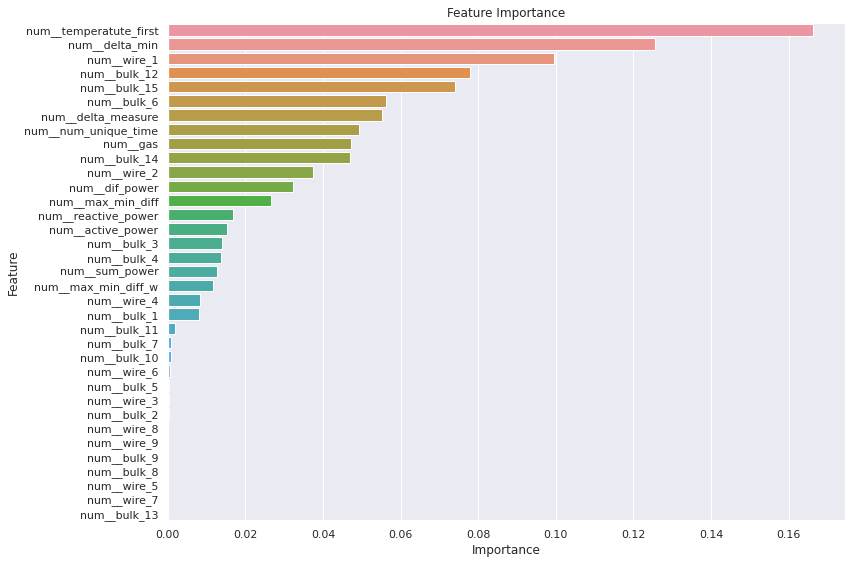

In [231]:
plt.figure(figsize=(12, 8))

sns.barplot(x='importance', y='feature', data=importance_df)

plt.xlabel('Importance')

plt.ylabel('Feature')

plt.title('Feature Importance')

plt.tight_layout()

plt.show()

In [232]:
explainer = shap.TreeExplainer(model)

In [233]:
shap_values = explainer.shap_values(X_test_transformed)

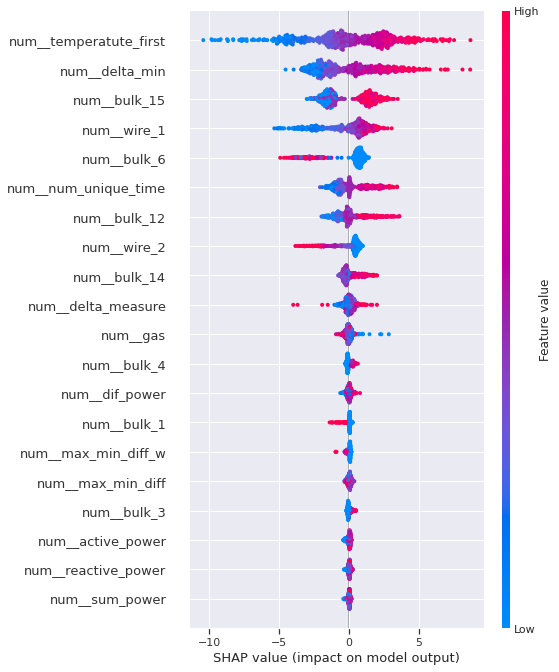

In [234]:
shap.summary_plot(shap_values, X_test_transformed, feature_names=feature_names)

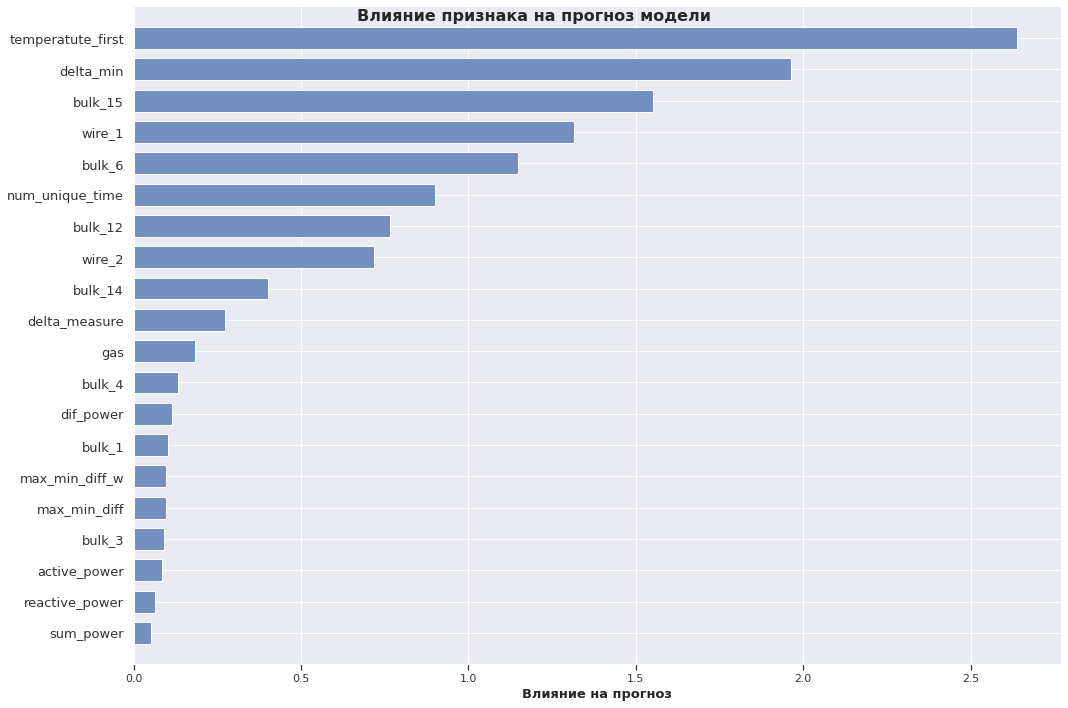

In [235]:
# Столбчатая диаграмма важности признаков
#ax = shap.summary_plot(shap_values[:,:,1], X_test, plot_type="bar", plot_size=(15, 10), color='#7490C0', show=False)
ax = shap.summary_plot(shap_values, X_test, plot_type="bar", plot_size=(15, 10), color='#7490C0', show=False)
plt.suptitle("Влияние признака на прогноз модели", fontweight='bold', fontsize=16)
plt.xlabel('Влияние на прогноз', fontweight='bold')
plt.show()

feature_importances_ и shap_values показали немного разные результаты, поскольку у них разные подходы к оценке важности. feature_importances_ — это глобальная, встроенная метрика, в то время как SHAP — предоставляет объяснения для каждого экземпляра и может учитывать взаимодействия признаков и их влияние в конкретных случаях.
SHAP учитывает взаимодействия признаков, а feature_importances_ — нет.

Тем не менее, самыми важными признаками являются temperatute_first (первая измеренная температура), delta_min (разница между окончанием нагрева и началом нагрева, мин.), wire_1 (объем проволочного материала 1) и bulk_15 (объем сыпучего материала 15).

Посмотрим более внимательно на связь целевого признака и первой измеренной температуры.

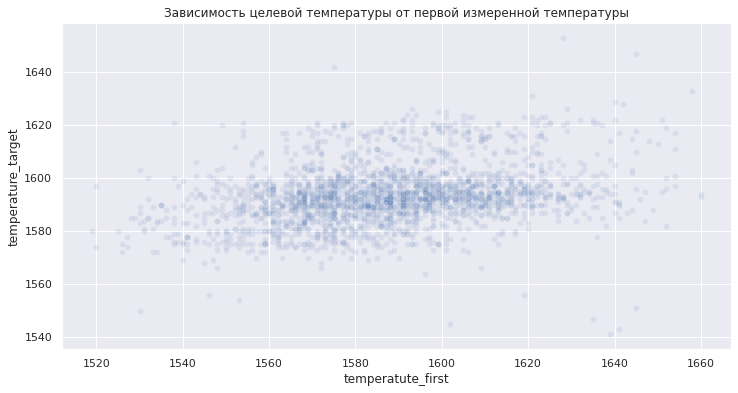

In [236]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=result_table, 
    x="temperatute_first", 
    y="temperature_target",
    alpha=0.1
    #hue="", 
    #size=""
    
)
plt.title('Зависимость целевой температуры от первой измеренной температуры');

По условию задачи требуется уменьшить потребление электроэнергии на этапе обработки стали, то есть нас интересуют более низкие целевые температуры.

Из графика видно, что наиболее плотное облако точек с температурой ниже 1600 ⁰С наблюдается, когда первая измеренная температура лежит в пределах 1570-1620 ⁰С. То есть, наверное, имеет смысл более строго контролировать эту температуру. 

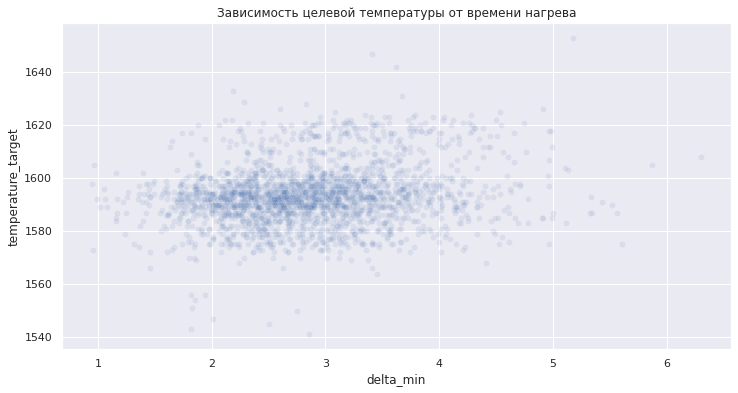

In [237]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=result_table, 
    x="delta_min", 
    y="temperature_target",
    alpha=0.1
    #hue="", 
    #size=""
    
)
plt.title('Зависимость целевой температуры от времени нагрева');

Время нагрева, по-видимому, лучше также оптимизировать и поддерживать его в диапазоне 1.8 - 3.5 минут.

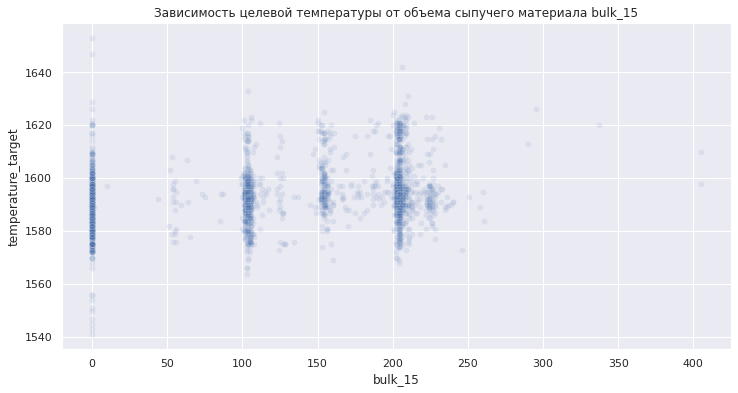

In [238]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=result_table, 
    x="bulk_15", 
    y="temperature_target",
    alpha=0.1
    #hue="", 
    #size=""
    
)
plt.title('Зависимость целевой температуры от объема сыпучего материала bulk_15');

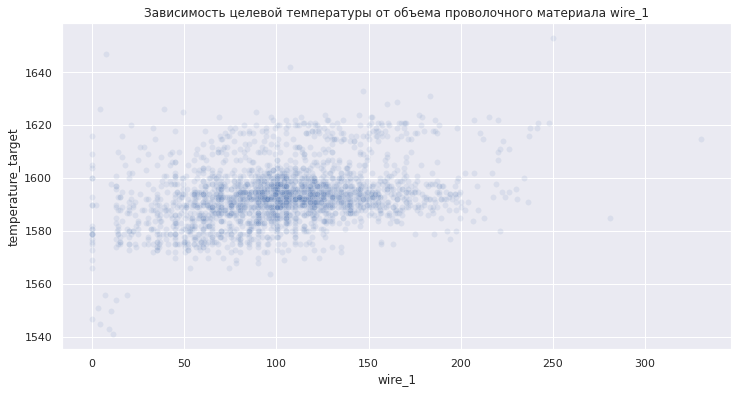

In [239]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=result_table, 
    x="wire_1", 
    y="temperature_target",
    alpha=0.1
    #hue="", 
    #size=""
    
)
plt.title('Зависимость целевой температуры от объема проволочного материала wire_1');

В случае добавления материалов в сталь не очень понятно, как бы можно было улучшить процесс, поскольку порядок добавления и количество менять нельзя. Мне казалось, что добавление материала в сталь должно приводить к снижению температуры сплава. Следовательно, после этого надо будет повышать температуру. По-видимому, чтобы уменьшить энергозатраты, надо оптимизировать именно этот компенсирующий подогрев, регулируя мощность и время нагрева. Может быть, неплохо было бы ввести в модель параметры, относящиеся к длительностям коменсирующих нагревов.

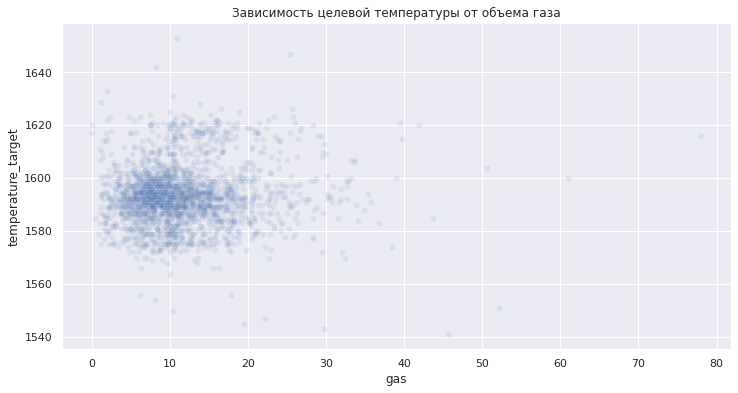

In [240]:
plt.figure(figsize=(12,6))
sns.scatterplot(
    data=result_table, 
    x="gas", 
    y="temperature_target",
    alpha=0.1
    #hue="", 
    #size=""
    
)
plt.title('Зависимость целевой температуры от объема газа');

Исходя из общих соображений, именно этот параметр должен был бы сильно влиять на температуру в ковше. Температуры от 1580 до 1600 получаются при объеме газа в диапазоне от 5 до 15. Наверное, тут неплохо было бы ввести дополнительные параметры, касающиеся скорости подачи газа (л/мин?) и время воздействия.

<a id='7'></a>
## Выводы

Для построения модели, предсказывающей температуру сплава, было предоставлено семь таблиц с данными об электродах, объёме и времени подачи сыпучих материалов, о продувке сплава газом, об измерениях температуры, объёме и времени подачи проволочных материалов.

В таблицах были обнаружены пропуски, аномальные значения, несоответствия типов данных.
В процессе предобработки данных были переименованы столбцы, тип данных приведен к правильному, исключены аномальные значения.
Были созданы новые признаки, относящиеся к ковшу в целом.

К ним относятся:
- полная мощность (корень квадратный из суммы квадратов активной и реактивной),
- отношение активной и реактивной мощностей,
- время нагрева,
- длительность добавления материалов (разница по времени между последним и первым добавлением материала),
- первая измеренная температура стали,
- разница между последним и первым измерением температуры,
- число замеров температуры,
- целевой признак – последняя измеренная температура сплава.

Было проведено аггрегирование данных по партии и внутреннее объединение всех таблиц по номеру партии.

Для установления корреляций между целевым параметром и остальными признаками использовалась корреляция Phi_K. 

Из корреляционной матрицы видно, что между большинством признаков корреляция очень низкая или отсутствует.

Однако между небольшим количеством признаков корреляция больше 0.9, то есть наблюдается коллинеарность. Так, мультиколлинеаронсть наблюдается для некоторых признаков, относящихся к объемам добавляемых материалов. Это означает, что некоторые материалы всегда добавляют вместе (например, bulk_8 и wire8, bulk_9 и wire8). Для линейной регрессии надо было бы избавляться от таких признаков.

Корреляционный анализ показывает, что целевой признак (temperature_target) лучше всего коррелирует с такимми признаками как bulk_7, 2; wire_4, 7, 3, max_min_df_w. Интересно, что корреляция с признаками, оносящимися к мощности - отсутствует.

Данные были разделены на тренировочную и тестовую выборки (test_size = 0.25).

Рассмотрены следующие классы моделей:
- случайный лес,
- бустинг,
- нейронная сеть.

По условию задачи в качестве метрики качества будем использовать MAE.
Будем выбирать лучшую модель по значению метрики на кросс-валидации.
Используем метод автоматизированного подбора гиперпараметров: RandomizedSearchCV.

Лучшей моделью оказалась модель RandomForestRegressor (случайный лес) с параметрами: max_depth=39, min_samples_leaf=4, min_samples_split=4, n_estimators=250, random_state=110825. Метрика лучшей модели на кросс-валидации: -6.68.

Метрика лучшей модели на кросс-валидации: -6.68. MAE = 6.68.

Результаты для всех рассмотренных моделей:

- Model	Best_score
- CatBoost	7.344904
- RandomForest	6.676079
- keras_reg	34.441516


Значение метрики MAE лучшей модели на тестовой выборке составило 6.38 (что менее 6.8, требуемых по условию задачи).
Значение метрики MAE на константной модели на 20% хуже, чем у RandomForest.


Самыми важными признаками являются:
- temperatute_first (первая измеренная температура),
- delta_min (разница между окончанием нагрева и началом нагрева, мин.), 
- wire_1 (объем проволочного материала 1),
- bulk_15 (объем сыпучего материала 15).

По условию задачи требуется уменьшить потребление электроэнергии на этапе обработки стали, то есть нас интересуют более низкие целевые температуры.
Исходя из анализа самых важных для модели признаков, можно дать следующие рекомендации:
Требуется более строгий контроль важных признаков в узких диапазонах.

- Первая измеренная температура должна поддерживаться в пределах 1570-1620 ⁰С. 
- Время нагрева, по-видимому, лучше также оптимизировать и поддерживать его в диапазоне 1.8 - 3.5 минут.
- В случае добавления материалов в сталь не очень понятно, как бы можно было улучшить процесс, поскольку порядок добавления и количество менять нельзя. По-видимому, чтобы уменьшить энергозатраты, надо оптимизировать компенсирующий подогрев, регулируя мощность и время нагрева.
По возможности ввести в модель параметры, относящиеся к длительностям коменсирующих нагревов.
- Также можно ввести дополнительные параметры, касающиеся скорости подачи газа (л/мин?) и время воздействия.

Поддержание измеряемых признаков в более узких диапазонах позволило бы уменьшить количество нелогичных выбросов в данных, что помогло бы улучшить качество модели.